## Introduction
League of legends is an online game where two teams composed of five players each battles one another. The goal of the game is to destroy a structure situated in the enemy base and therefore there's no possibility of a draw. Games usually last about 25 to 30 minutes and during that time there are a series of events which can change the balance between the two teams: kills, towers destroyed, dragon taken and so on.

The aim of this project is to analyze, using a bayesian network, how the differents stats taken at the 10 minute mark of a game influence the final win.



In [224]:
import itertools

from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import BicScore

In [225]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Dataset
The dataset used can be found [here](https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min).
This dataset contains the first 10 minutes stats of 10k ranked games from a high ELO (DIAMOND I to MASTER). Players have roughly the same level.
There are 19 features per team (38 in total) collected after 10min in-game. This includes kills, deaths, gold, experience, level...

The column blueWins is the target value. A value of 1 means the blue team has won, 0 otherwise.

With the dataset there is also a nice analysis of data [here](https://www.kaggle.com/code/xiyuewang/lol-how-to-win).

For our purposes we decide to use as features, and aleatory variables, the differences between the two teams in differents statistics of the game.

The feature computed from the dataset are:
 1. blueWins: **1** blue teams wins **0** red team wins, there is no draw
 2. goldDiff: gold difference between the two teams. It is measure of how much a team is in advantage
 3. expDiff: experience difference between the two teams. Another measure of how much a team is in advantage
 4. killsDiff: compute as "bluesKills" - "redKills", is the difference between the kills of the two teams
 5. minionsDiff: computed as "blueTotalMinionsKilled" - "redTotalMinionsKilled", is the difference between the minions killed by the two teams
 6. towersDiff: computed as "blueTowersDestroyed" - "redTowersDestroyed". Towers are fortifications which defends the teams. The destruction of the towers is crucial to have an advantage
 7. dragonsDiff: computed as "blueDragons" - "redDragons". Dragons are enemies scattered in the map. Killing a dragon gives to the team additional stats.
 8. blueHeralds: Heralds are enemies scattered in the map. Killing a Herald gives to the team a friendly minion which is very effective against the enemies tower.
 9. redHeralds: same as above.

In [226]:

def create_dataset(data):
    columns = ["blueWins", "blueGoldDiff", "blueExperienceDiff", "blueHeralds", "redHeralds"]
    dataset = data.loc[:, columns]
    dataset["killsDiff"] = data.apply(lambda row: row["blueKills"]-row["redKills"], axis=1)
    dataset["minionsDiff"] = data.apply(lambda row: row["blueTotalMinionsKilled"]-row["redTotalMinionsKilled"], axis=1)
    dataset["dragonsDiff"] = data.apply(lambda row: row["blueDragons"]-row["redDragons"], axis=1)
    dataset["towersDiff"] = data.apply(lambda row: row["blueTowersDestroyed"]-row["redTowersDestroyed"], axis=1)
    return dataset

## Discretization
Discretization is the process through which we can transform continuous variables into a discrete form. We do this by creating a set of contiguous bins that go across the range of our desired variable.
First we compute our feature and after we discretize them using one of the following set of labels:
1. "True", "False": used for values that have only two possibile values.
    - blueWins
    - blueHeralds
    - redHeralds
2. "Negative", "Neutral", "Positive": used for all the statistics that usually are quite similar for both teams at 10 minutes game.
    - minionsDiff
    - dragonsDiff
    - towersDiff
2. "Very Negative", "Negative", "Neutral", "Positive", "Very Positive": used for the statistics that could be very different also at the start of the game
    - blueGoldDiff
    - blueExperienceDiff
    - killsDiff

The values are chosen in a way that the data are balanced between the bins.
We expect this type of ordering between the cardinality of the categories:

Neutral >~ Positive ≈ Negative > Very Positive ≈ Very Negative

In [227]:
negative_neutral_positive = ["Negative", "Neutral", "Positive"]
negative_neutral_positive_aug = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
true_false = ["True", "False"]

variables_to_values = {
    "minionsDiff": negative_neutral_positive,
    "dragonsDiff": negative_neutral_positive,
    "towersDiff": negative_neutral_positive,

    "blueGoldDiff": negative_neutral_positive_aug,
    "blueExperienceDiff": negative_neutral_positive_aug,
    "killsDiff": negative_neutral_positive_aug,

    "blueWins": true_false,
    "blueHeralds": true_false,
    "redHeralds": true_false,
}

def discretize(data):
    dataset = data.copy()

    dataset["minionsDiff"] = pd.cut(dataset["minionsDiff"], bins=[-np.inf, -15, +15, np.inf], labels=variables_to_values["minionsDiff"], include_lowest = True)
    dataset["dragonsDiff"] = pd.cut(dataset["dragonsDiff"], bins=[-np.inf, -1, 0, np.inf], labels=variables_to_values["dragonsDiff"], include_lowest = True)
    dataset["towersDiff"] = pd.cut(dataset["towersDiff"], bins=[-np.inf, -1, 0, np.inf], labels=variables_to_values["towersDiff"], include_lowest = True)

    
    dataset["blueGoldDiff"] = pd.cut(dataset["blueGoldDiff"], bins=[-np.inf, -2500, -1000, 1000, 2500, np.inf], labels=variables_to_values["blueGoldDiff"], include_lowest = True)
    dataset["blueExperienceDiff"] = pd.cut(dataset["blueExperienceDiff"], bins=[-np.inf,-2000,-750, 750, 2000, np.inf], labels=variables_to_values["blueExperienceDiff"], include_lowest = True)
    dataset["killsDiff"] = pd.cut(dataset["killsDiff"], bins=[-np.inf,-4, -2, 2, 4, np.inf], labels=variables_to_values["killsDiff"], include_lowest = True)


    true_false = {1: "True", 0: "False"}
    dataset = dataset.replace({"blueWins": true_false, "blueHeralds": true_false, "redHeralds": true_false})

    return dataset

In [228]:
path = "high_diamond_ranked_10min.csv"
data = pd.read_csv(path)
data.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [229]:
data_clean = create_dataset(data)
dataset = discretize(data_clean)
dataset.head()
#for column in dataset:
    #print(pd.value_counts(dataset[column]))


,blueWins,blueGoldDiff,blueExperienceDiff,blueHeralds,redHeralds,killsDiff,minionsDiff,dragonsDiff,towersDiff
0,False,Neutral,Neutral,False,False,Positive,Neutral,Neutral,Neutral
1,False,Very Negative,Negative,False,True,Neutral,Negative,Negative,Negative
2,False,Negative,Negative,False,False,Very Negative,Negative,Positive,Neutral
3,False,Negative,Neutral,True,False,Neutral,Negative,Neutral,Neutral
4,False,Negative,Neutral,False,False,Neutral,Negative,Negative,Neutral


In [230]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   blueWins            9879 non-null   object  
 1   blueGoldDiff        9879 non-null   category
 2   blueExperienceDiff  9879 non-null   category
 3   blueHeralds         9879 non-null   object  
 4   redHeralds          9879 non-null   object  
 5   killsDiff           9879 non-null   category
 6   minionsDiff         9879 non-null   category
 7   dragonsDiff         9879 non-null   category
 8   towersDiff          9879 non-null   category
dtypes: category(6), object(3)
memory usage: 290.6+ KB


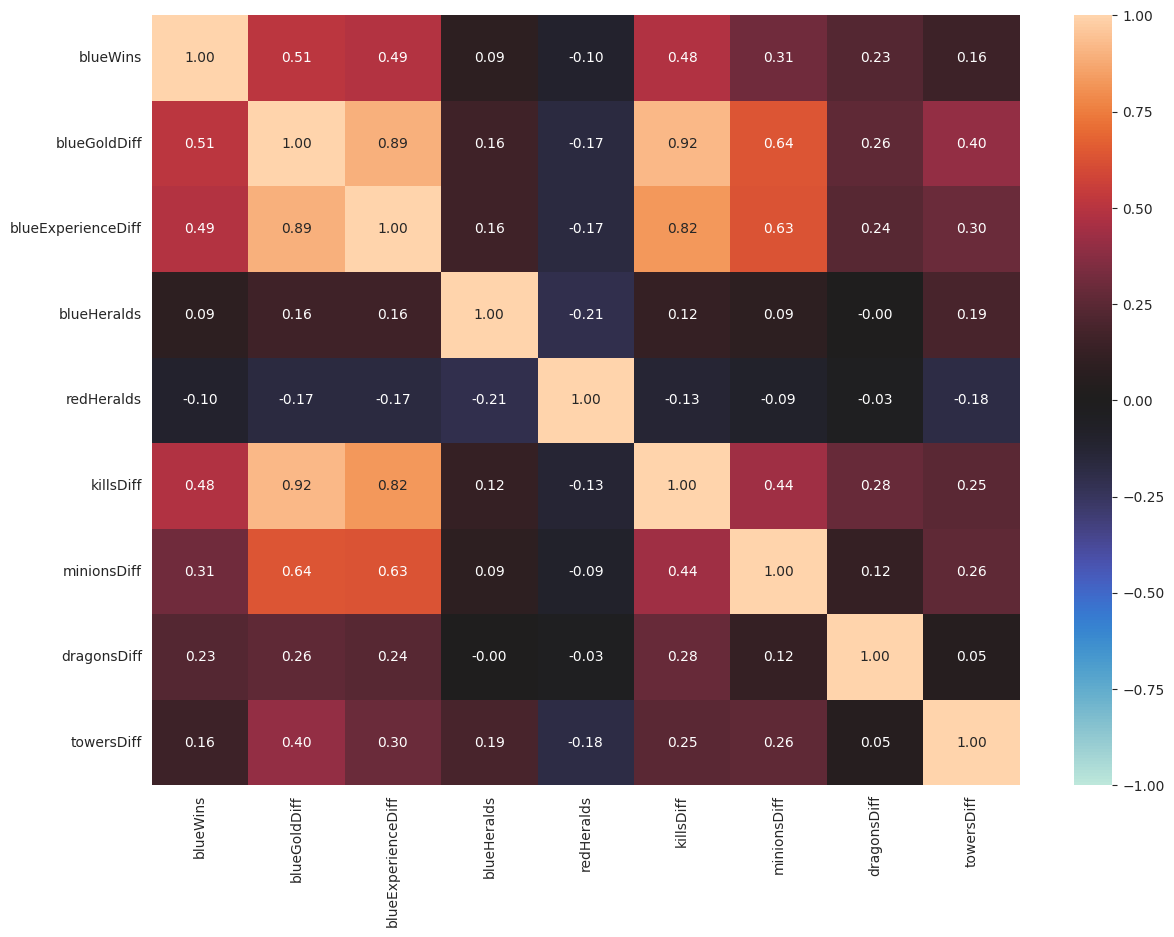

In [231]:
# Correlation matrix
def draw_correlation_matrix(dataset, figsize=(14, 10)):
    plt.figure(figsize=figsize)
    sns.heatmap(dataset.corr(), center=0, annot=True, fmt='.2f', vmin=-1, vmax=1)
#cmap='YlGnBu'
draw_correlation_matrix(data_clean)

# Bayesian networks
Let's build our bayesian network using two different approaches:
1. Manual approach: the net is built using our personal knoweldge of the topic.
2. Hill Climbing search: a greedy local search that starts from the DAG start (default: disconnected DAG)

We will compare the two models by doing inferences and computing the BDeu score. We will also compare the different structure of the models, trying to understand if our conjectures abouts the relations between the variables were right.


In [232]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import pydot
import matplotlib.pyplot as plt

def draw_graph(model):
    pos = graphviz_layout(model, prog="dot")
    plt.figure(figsize=(10, 10))
    nx.draw(model, with_labels=True, pos=pos, node_size=3000, node_color="green")
    plt.savefig('model.png')
    plt.show()



## Manual Approach
We choose the following connections:
1. killsDiff   -> blueGoldDiff: killing other players provides gold.
2. minionsDiff -> blueGoldDiff: killing minions gives gold.
3. minionsDiff -> blueExperienceDiff: killing minions gives also experience.
4. towersDiff -> blueGoldDiff: destroying towers provides gold.
5. towersDiff -> blueWins: destroying a tower in the first 10min. is surely a first step for the victory.
6. blueHeralds -> towersDiff: as described above the herald are fundamental for the destruction of the enemies towers.
7. redHeralds -> towersDiff: same as the above.
8. dragonsDiff -> blueWins: killing dragons gives an advantage in stats for the team.
9. blueGoldDiff -> blueWins: more is gold difference more is the advantage of one team. Gold is used to buy items and stats for the team.
10. blueExperienceDiff -> blueWins: similar to the gold difference. The experience can be used to upgrade the players.

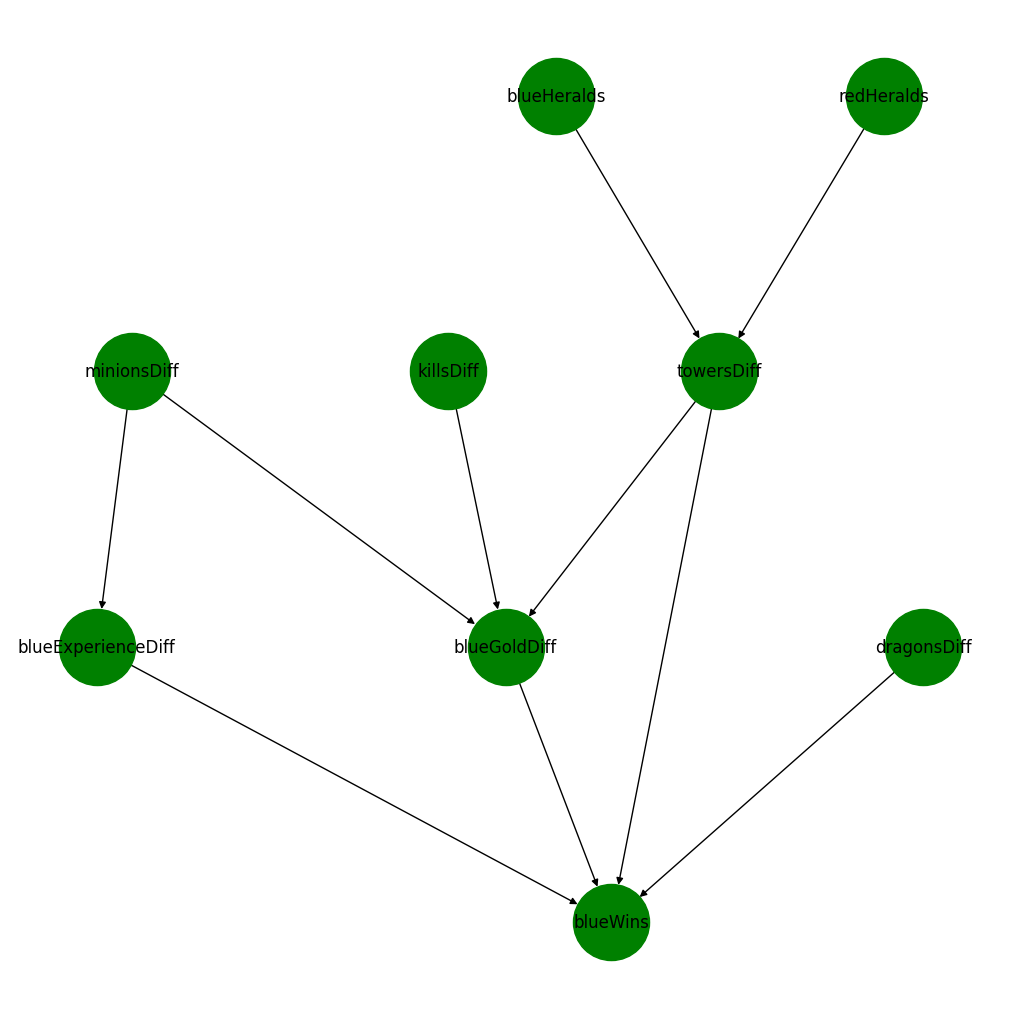

In [233]:
manual_model = BayesianNetwork([
    ("killsDiff", "blueGoldDiff"),
    ("minionsDiff", "blueGoldDiff"),
    ("minionsDiff", "blueExperienceDiff"),
    ("towersDiff", "blueGoldDiff"),
    ("towersDiff", "blueWins"),
    ("blueHeralds", "towersDiff"),
    ("redHeralds", "towersDiff"),
    ("dragonsDiff", "blueWins"),
    ("blueExperienceDiff", "blueWins"),
    ("blueGoldDiff", "blueWins")
])
draw_graph(manual_model)

## HillClimbing Search
The hill climb algorthm is a greedy local search for the DAG space (which is super-exponential). This strategy starts from a start DAG (usually a disconnected DAG) and proceeds by iteratively performing single-edge manipulations that maximally increase the score.
We have also added a **black list** to exclude all the edges outgoing the target node *blueWins* from the search.

  0%|          | 0/1000000 [00:00<?, ?it/s]

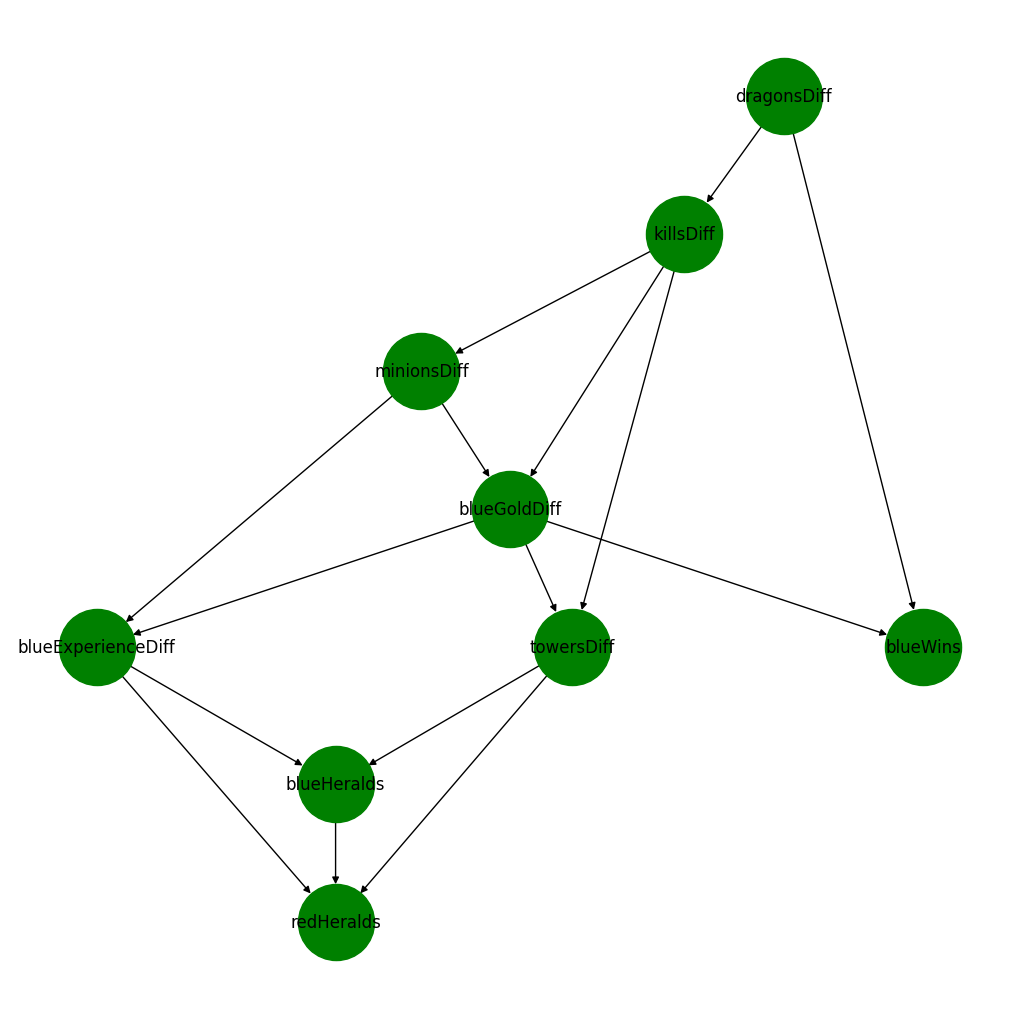

In [234]:
from pgmpy.estimators import HillClimbSearch, K2Score, ExhaustiveSearch, BicScore, BDeuScore, BDsScore, MmhcEstimator

estimator = HillClimbSearch(dataset)

black_list = [('blueWins', node) for node in dataset.columns[:-1]]
hillclimb_model = estimator.estimate(
    scoring_method=BDsScore(dataset), black_list=black_list)
hillclimb_model = BayesianNetwork(hillclimb_model)
draw_graph(hillclimb_model)


# Parameter Estimation
For computing the values of the CPDs we decided to use the pgmpy *parameter estimation*. Given a set of data samples and a DAG estimate the (conditional) probability distributions of the individual variables.
The *parameter estimator* used is the `BayesianEstimator` with BDeu as *priors*.

One common problem with parameters estimation is the lack of data. For example in one of the first version of our handmade model, there were nodes with more than four parents. This resulted, for some combinations of the parents, in probability values equals to 0. This was one of the reason that brought us to prefer a simpler model with less connection.

In [235]:
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator

manual_model.cpds = []

manual_model.fit(data=dataset,
            estimator=BayesianEstimator,
            prior_type="BDeu",
            equivalent_sample_size=10,
            complete_samples_only=False,
)

hillclimb_model.fit(data=dataset,
            estimator=BayesianEstimator,
            prior_type="BDeu",
            equivalent_sample_size=10,
            complete_samples_only=False,
)

#pd.options.display.max_columns = 2000

print(f"Check model: {manual_model.check_model()=}")
print(f"Check model: {hillclimb_model.check_model()=}")


for cpd in manual_model.get_cpds():
    print(f"CPT of {cpd.variable}")
    print(cpd)
    pass


Check model: manual_model.check_model()=True
Check model: hillclimb_model.check_model()=True
CPT of killsDiff
+--------------------------+----------+
| killsDiff(Negative)      | 0.156942 |
+--------------------------+----------+
| killsDiff(Neutral)       | 0.371423 |
+--------------------------+----------+
| killsDiff(Positive)      | 0.132774 |
+--------------------------+----------+
| killsDiff(Very Negative) | 0.196481 |
+--------------------------+----------+
| killsDiff(Very Positive) | 0.14238  |
+--------------------------+----------+
CPT of blueGoldDiff
+-----------------------------+-----+--------------------------+
| killsDiff                   | ... | killsDiff(Very Positive) |
+-----------------------------+-----+--------------------------+
| minionsDiff                 | ... | minionsDiff(Positive)    |
+-----------------------------+-----+--------------------------+
| towersDiff                  | ... | towersDiff(Positive)     |
+-----------------------------+-----+---

# Inference
In this section the models are queried with different targets and evidences. The query is computed using the variable elimination method implemented in pgmpy. The time spent to perform the request is also recorded.

In [236]:
from pgmpy.inference import VariableElimination

def inference(model, target, evidence, approximate=False, n_samples=10):
    if approximate:
        approx_infer = ApproxInference(model)
        phi = approx_infer.query(target, evidence=evidence,n_samples=n_samples, show_progress = False)
    else:
        model_inference = VariableElimination(model)
        phi = model_inference.query(target, evidence, show_progress=False)
    return phi

def plot_query_table(models, targets, evidence, scale=(2, 4), fontsize=12, approximate=False, n_samples=10):
    model_to_phi = {}
    names = []
    for model in models:
        start_time = time.time()
        model_to_phi[model] = inference(model.model, targets, evidence, approximate, n_samples)
        end_time = time.time()
        names.append(model.name + "\n Time: " + str(round(end_time-start_time, 4)) + " seconds")

    targets_values = {}
    for target in targets:
        targets_values[target] = variables_to_values[target]

    table_data = []
    combinations = list(itertools.product(*targets_values.values()))
    for combination in combinations:
        row_data = [*combination]

        for model in models:
            prob = round(model_to_phi[model].get_value(**dict(zip(targets_values.keys(), combination))), 4)
            row_data += [prob]

        table_data.append(row_data)

    fig, ax1 = plt.subplots(figsize=(len(combinations), len(targets) + len(models)))

    ccolors = np.full(len(targets) + len(models), "lavender")




    table = ax1.table(cellText=table_data,
                      cellLoc = "center",
                      colLabels= targets + names,
                      colColours = ccolors,
                      loc="bottom"
                      )

    table.scale(*scale)
    table.set_fontsize(fontsize)

    ax1.axis("off")

    title = f"P({', '.join(targets)} | {', '.join([f'{k}={v}' for (k, v) in evidence.items()])})\n {'Variable elimination' if not approximate else 'Rejection sampling'}"

    #ax1.text(0.5, 1.08, title,
     #        horizontalalignment='center',
     #        fontsize=20,
     #        transform = ax1.transAxes)
    ax1.set_title(title, y=1.0, pad=-100)


    #return tables


def print_queries(models):
    #blueWins, blueGoldDiff, towersDiff, killsDiff, blueExperienceDiff, blueHeralds, redHeralds, minionsDiff

    queries = [
        (["blueWins"], {"blueGoldDiff": "Positive"}),
        (["blueWins"], {"blueGoldDiff": "Very Positive"}),
        (["blueWins"], {"blueGoldDiff": "Positive", "towersDiff": "Positive"}),
        (["blueWins"], {"blueGoldDiff": "Positive", "towersDiff": "Negative"}),
        #(["blueWins"], {"blueGoldDiff": "Positive", "towersDiff": "Negative"}),
        (["blueWins"], {"blueGoldDiff": "Very Negative", "towersDiff": "Positive", "dragonsDiff": "Positive", "blueExperienceDiff": "Positive"}),
        (["blueGoldDiff"], {"blueWins": "True"}),

        # Active v-structure
        (["blueExperienceDiff"], {"dragonsDiff": "Positive", "blueWins": "True"}),
        (["killsDiff"], {"blueWins": "True"}),

        # Active v-structure long
        (["killsDiff"], {"blueHeralds": "True", "blueGoldDiff": "Positive"}),
        (["killsDiff"], {"blueHeralds": "False", "blueGoldDiff": "Positive"}),

        # Non active v-structure
        (["killsDiff"], {"blueHeralds": "True", "blueGoldDiff": "Positive", "towersDiff": "Positive"}),
        (["killsDiff"], {"blueHeralds": "False", "blueGoldDiff": "Positive", "towersDiff": "Positive"}),
    ]

    
    for query in queries:
        plot_query_table(models, *query, scale=(4,4))


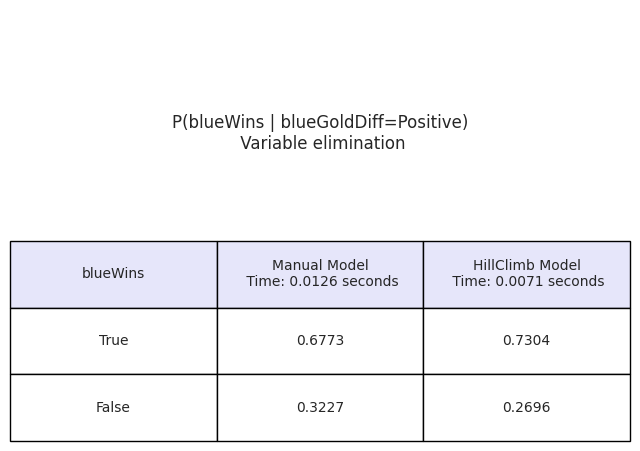

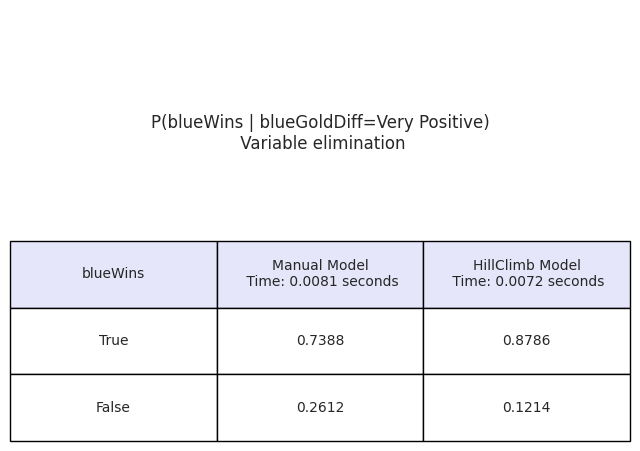

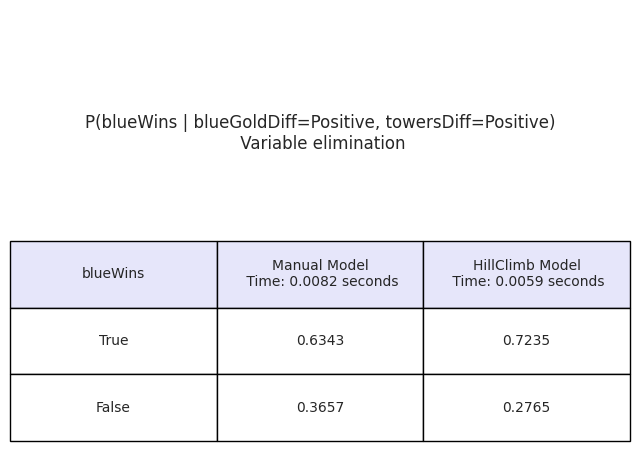

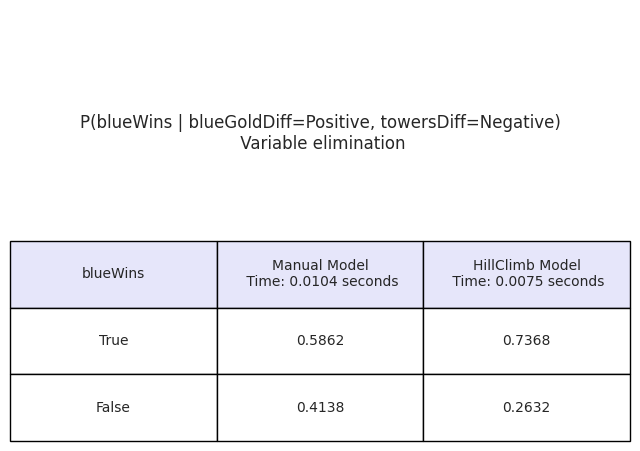

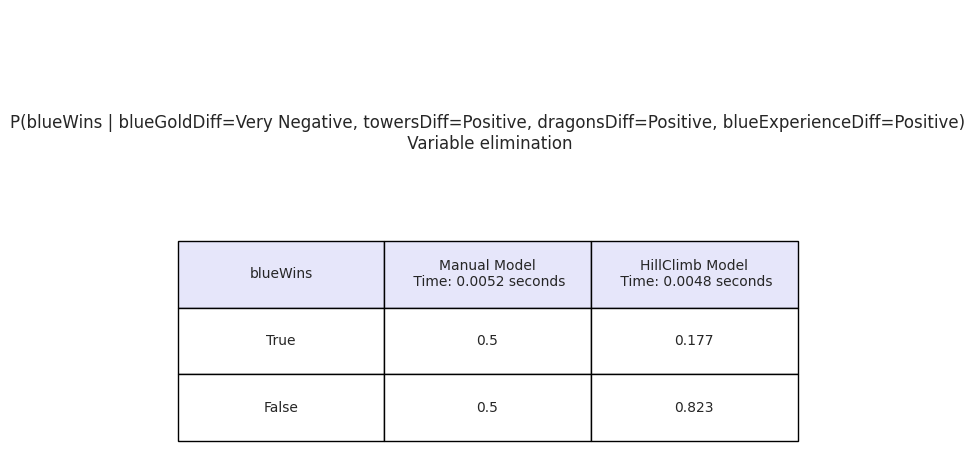

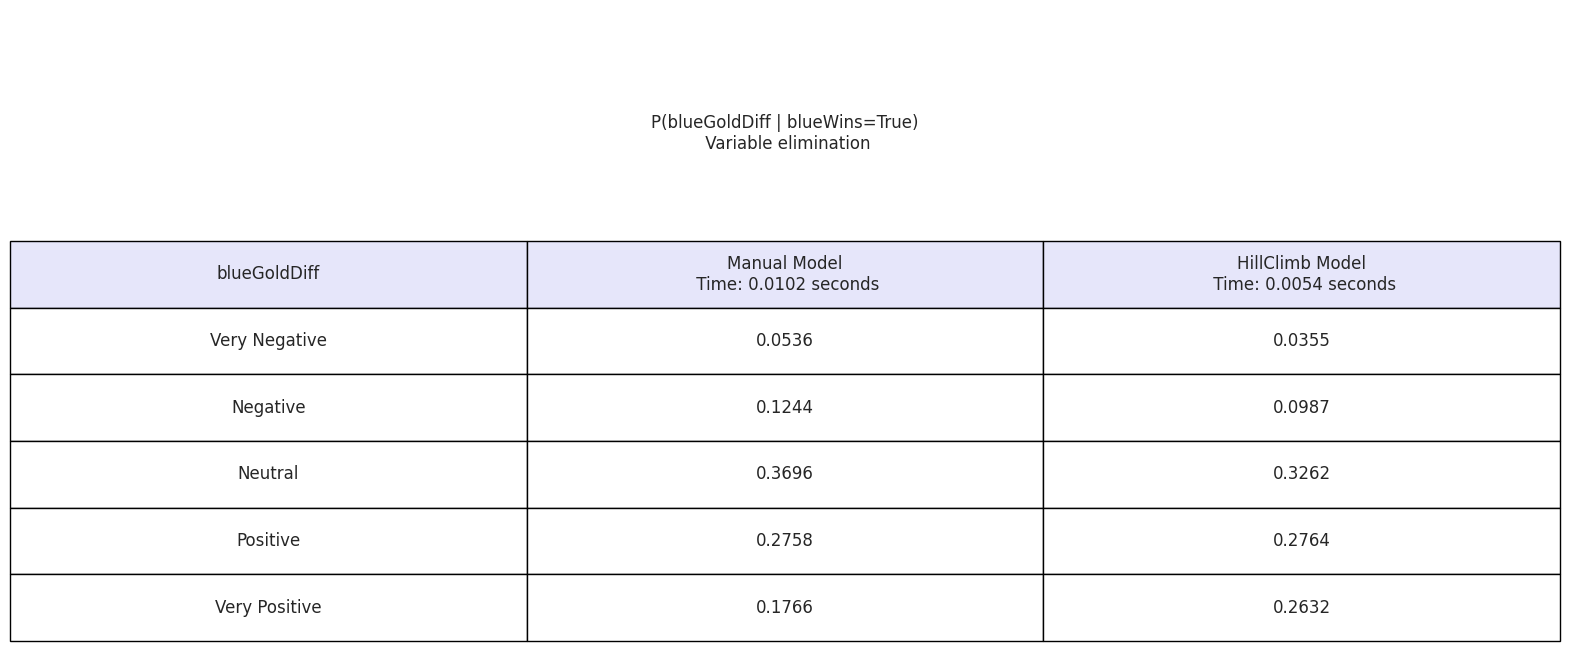

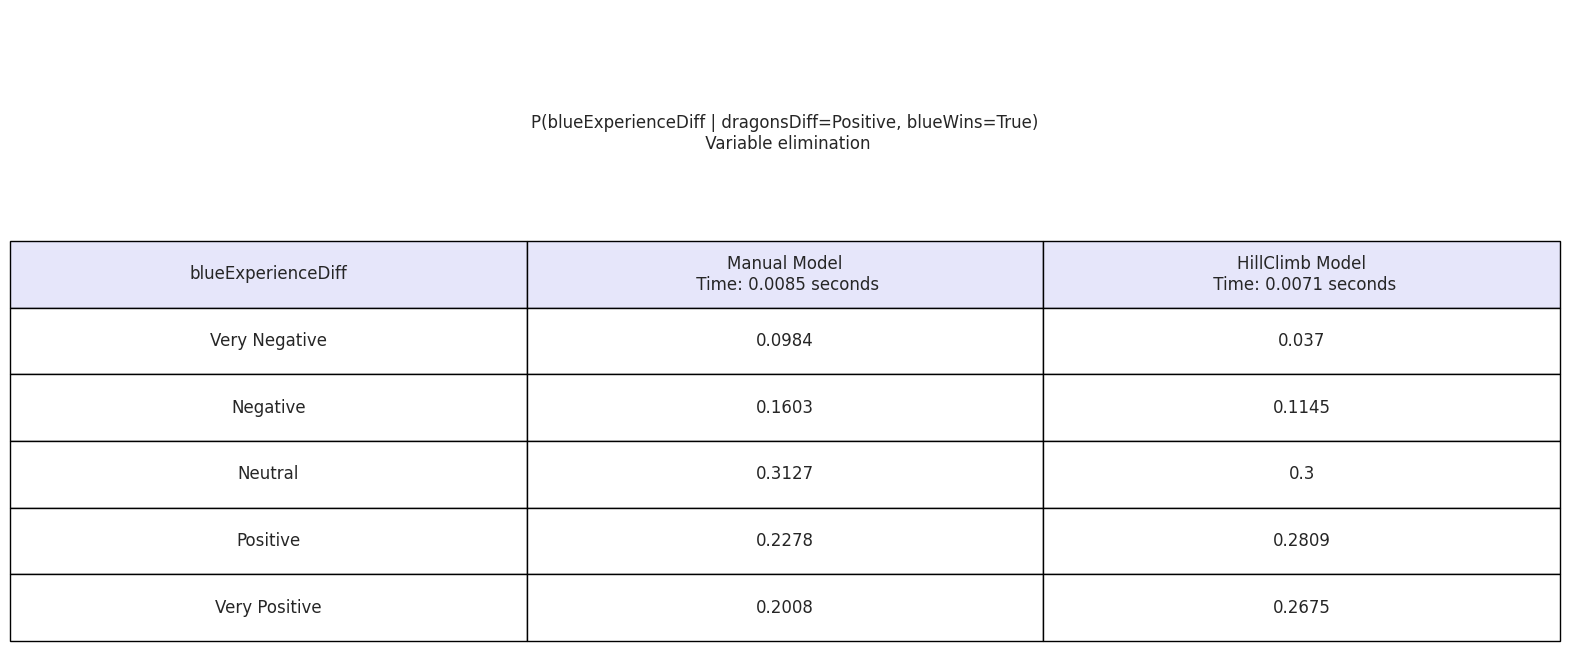

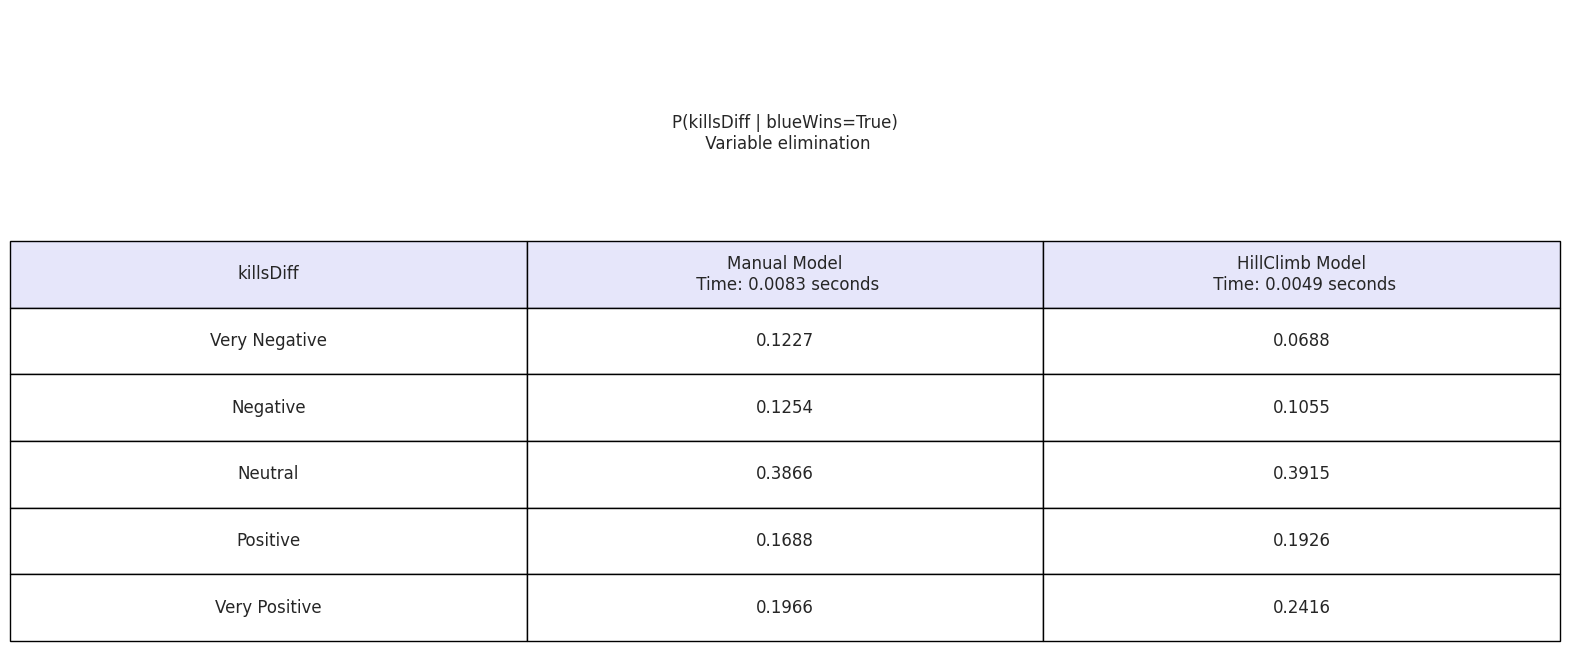

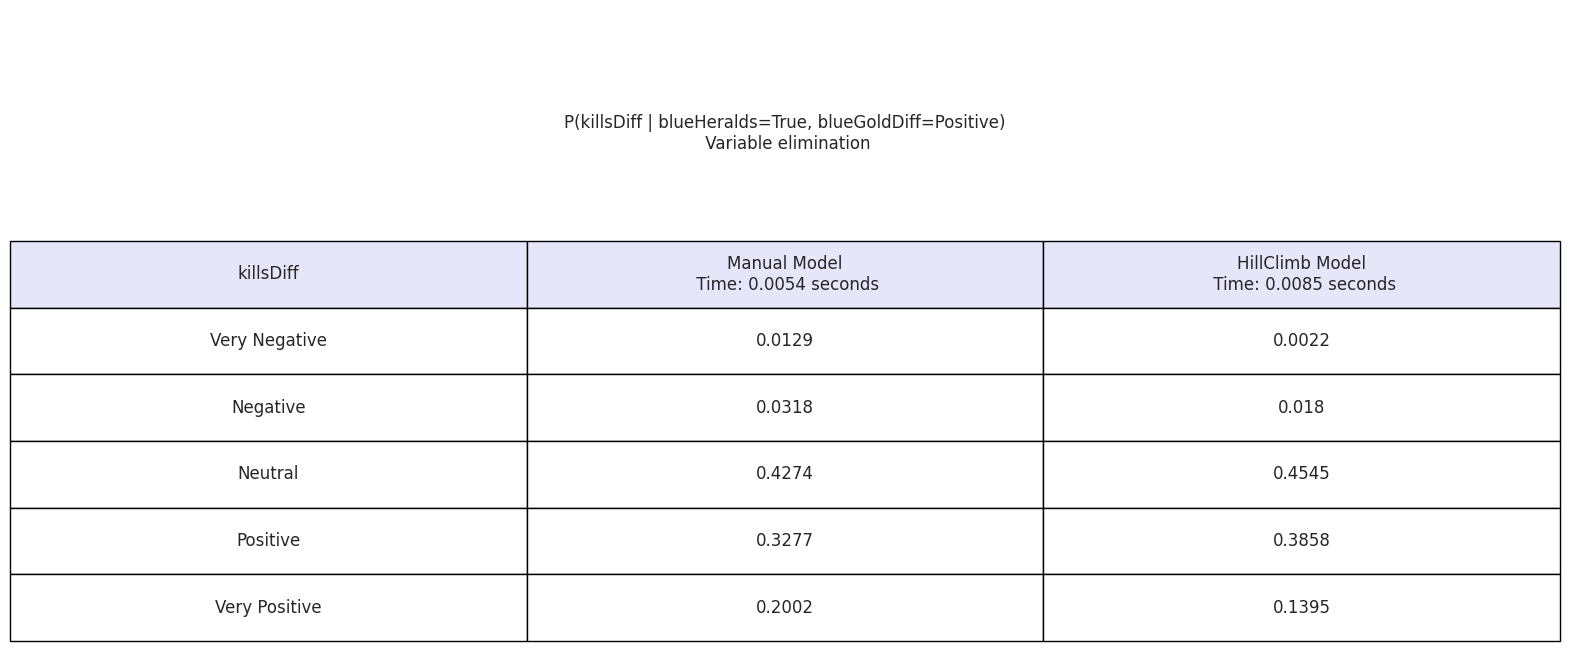

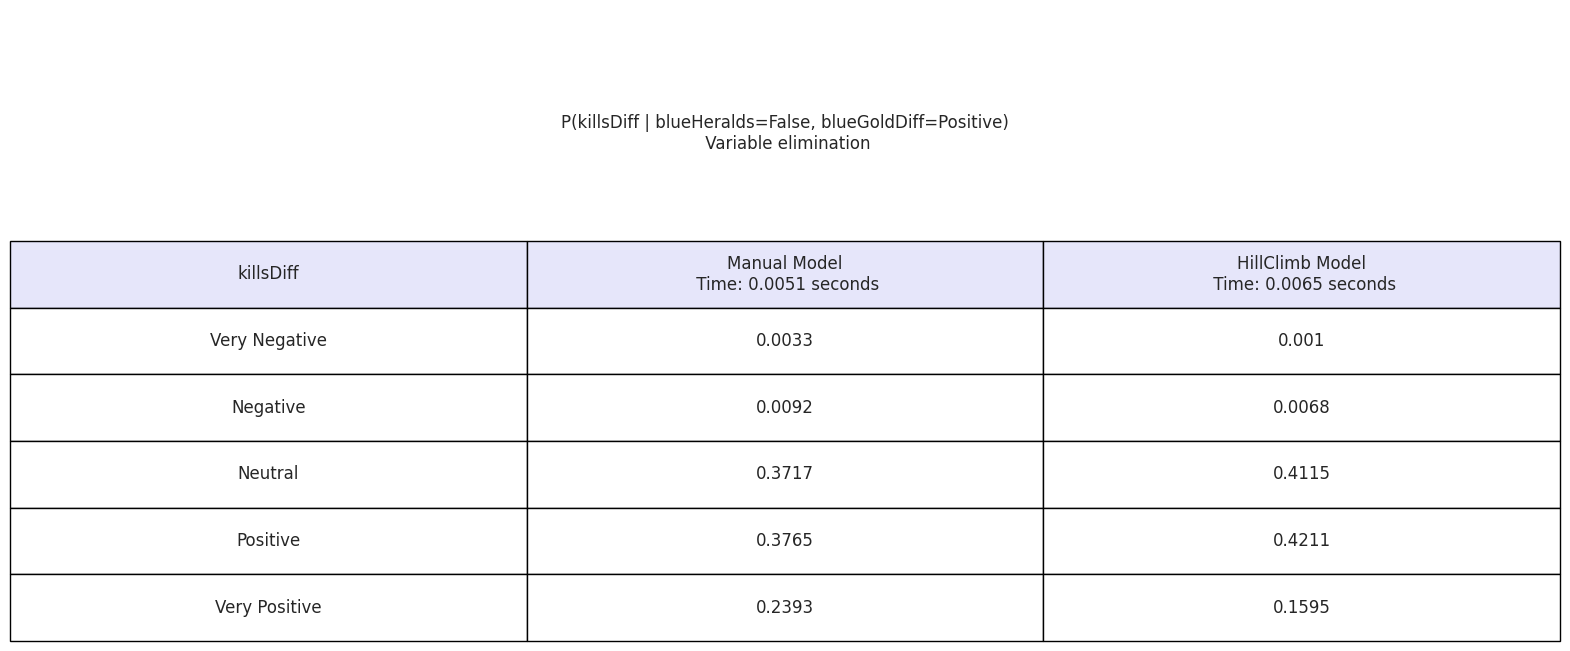

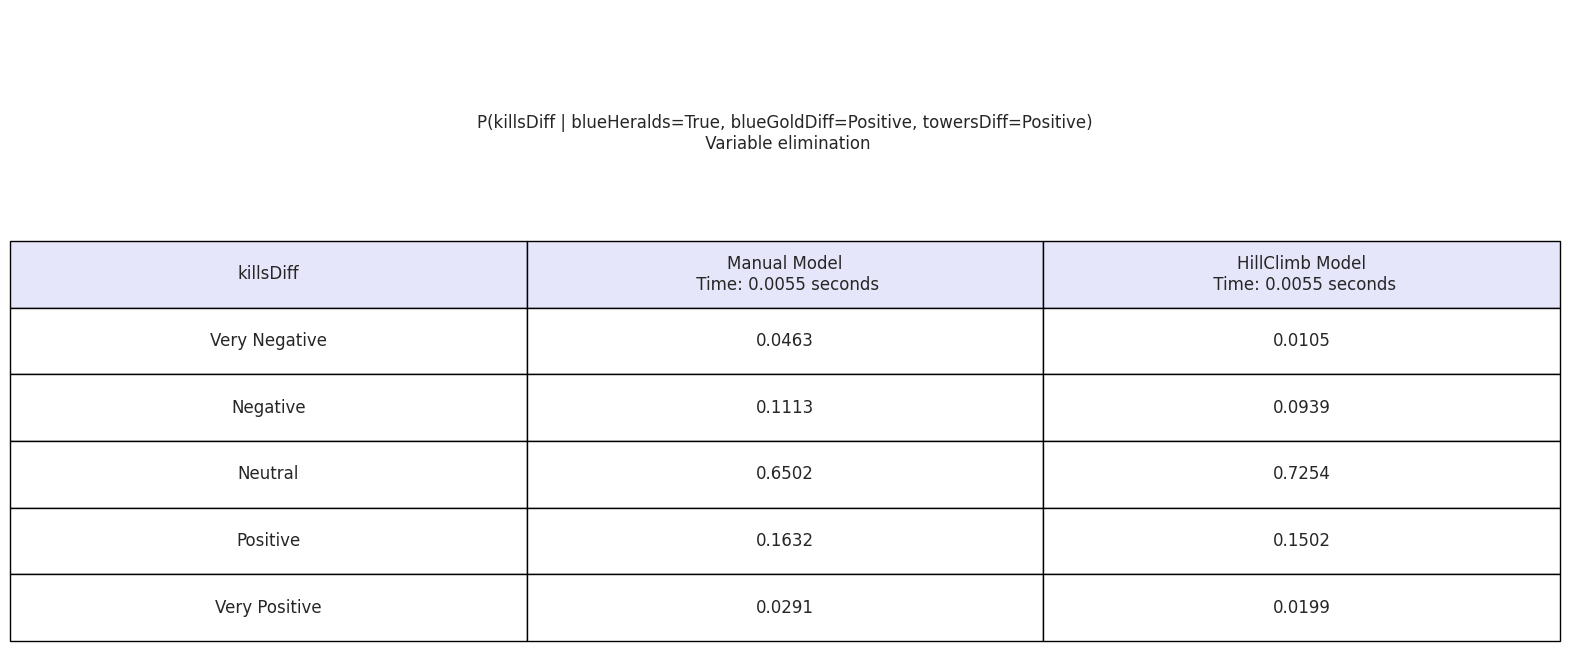

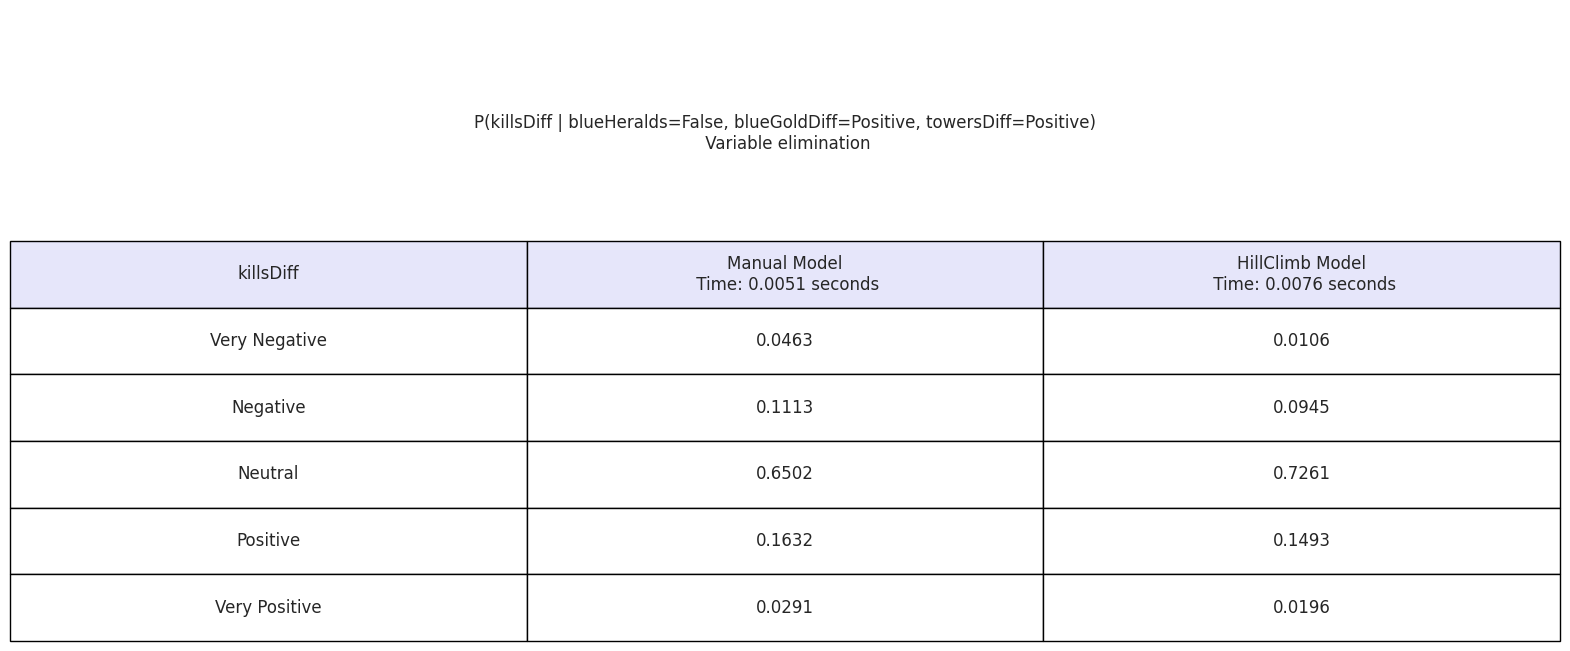

In [237]:
class Model:
    def __init__(self, model, name, dataset):
        self.model = model
        self.name = name
        self.dataset = dataset

models = [
    Model(model=manual_model, name="Manual Model", dataset=dataset),
    Model(model=hillclimb_model, name="HillClimb Model", dataset=dataset),
]

print_queries(models)


# Active trails and Markov blanket
An active trail represent the presence of influence between two variables X and Y given some evidence.
Computing the active trail of a node shows us which are the others variables that influence/ are influenced.

Instead, the Markov Blanket for a node x is: the set of evidence needed to isolate a node from the rest of the graph.
In a Bayesian network is defined as:
1. Parent's of the node.
2. Children's of the node.
3. Parent's of the children's.

In [238]:
def active_trails_of(query, evidence, model):
    active = model.active_trail_nodes(query, observed=evidence).get(query)
    active.remove(query)
    if active:
        if evidence:
            print(f'Active trails between \'{query}\' and {active} given the evidence {set(evidence)}.')
        else:
            print(f'Active trails between \'{query}\' and {active} given no evidence.')
    else:
        print(f'No active trails for \'{query}\' given the evidence {set(evidence)}.')

active_trails_of("blueGoldDiff", ["blueWins", "towersDiff"], manual_model)
active_trails_of("blueGoldDiff", ["blueWins", "towersDiff"], hillclimb_model)




def markov_blanket_of(node, model):
    print(f'Markov blanket of \'{node}\' is {set(model.get_markov_blanket(node))}')

    return 

markov_blanket_of('blueGoldDiff', manual_model)
markov_blanket_of('blueGoldDiff', hillclimb_model)


Active trails between 'blueGoldDiff' and {'dragonsDiff', 'killsDiff', 'blueExperienceDiff', 'minionsDiff'} given the evidence {'blueWins', 'towersDiff'}.
Active trails between 'blueGoldDiff' and {'dragonsDiff', 'killsDiff', 'blueExperienceDiff', 'blueHeralds', 'minionsDiff', 'redHeralds'} given the evidence {'blueWins', 'towersDiff'}.
Markov blanket of 'blueGoldDiff' is {'dragonsDiff', 'blueWins', 'blueExperienceDiff', 'minionsDiff', 'killsDiff', 'towersDiff'}
Markov blanket of 'blueGoldDiff' is {'dragonsDiff', 'blueWins', 'blueExperienceDiff', 'minionsDiff', 'killsDiff', 'towersDiff'}


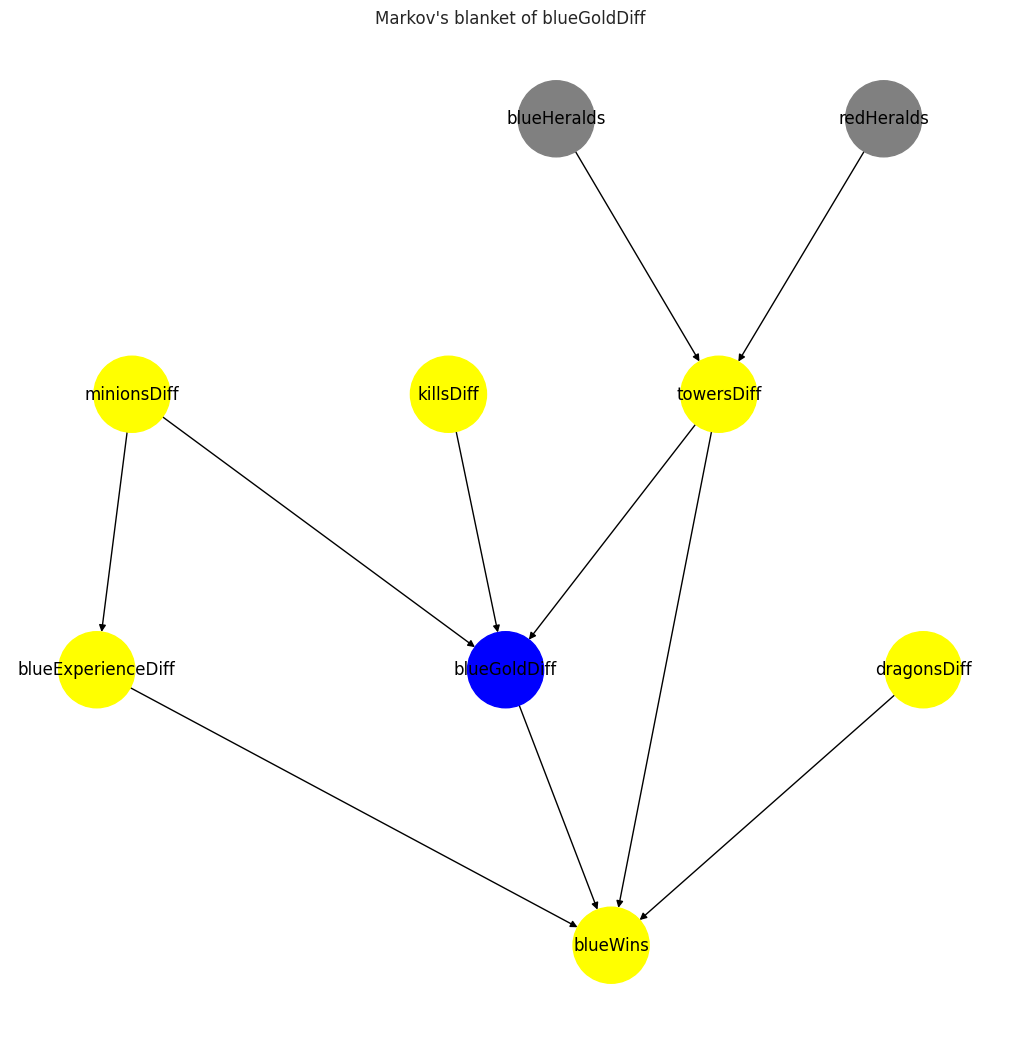

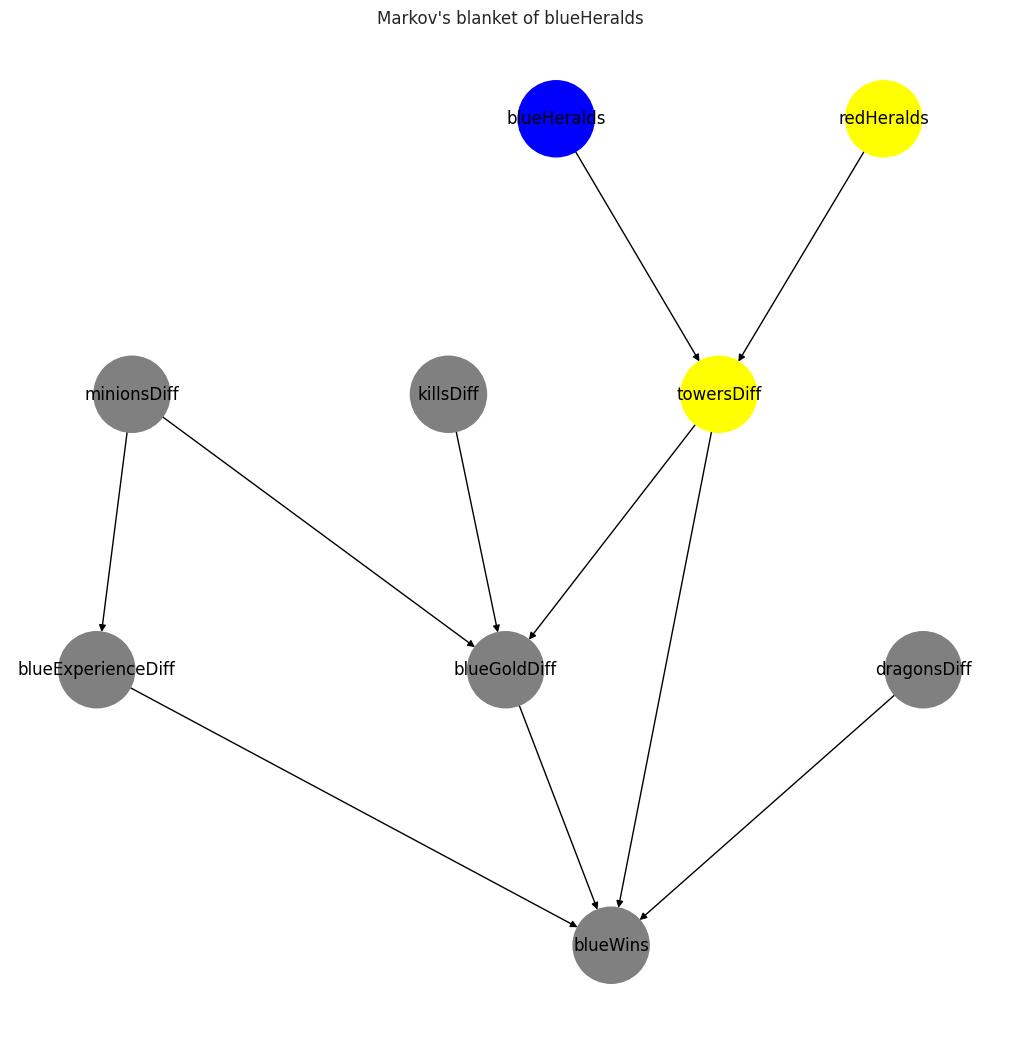

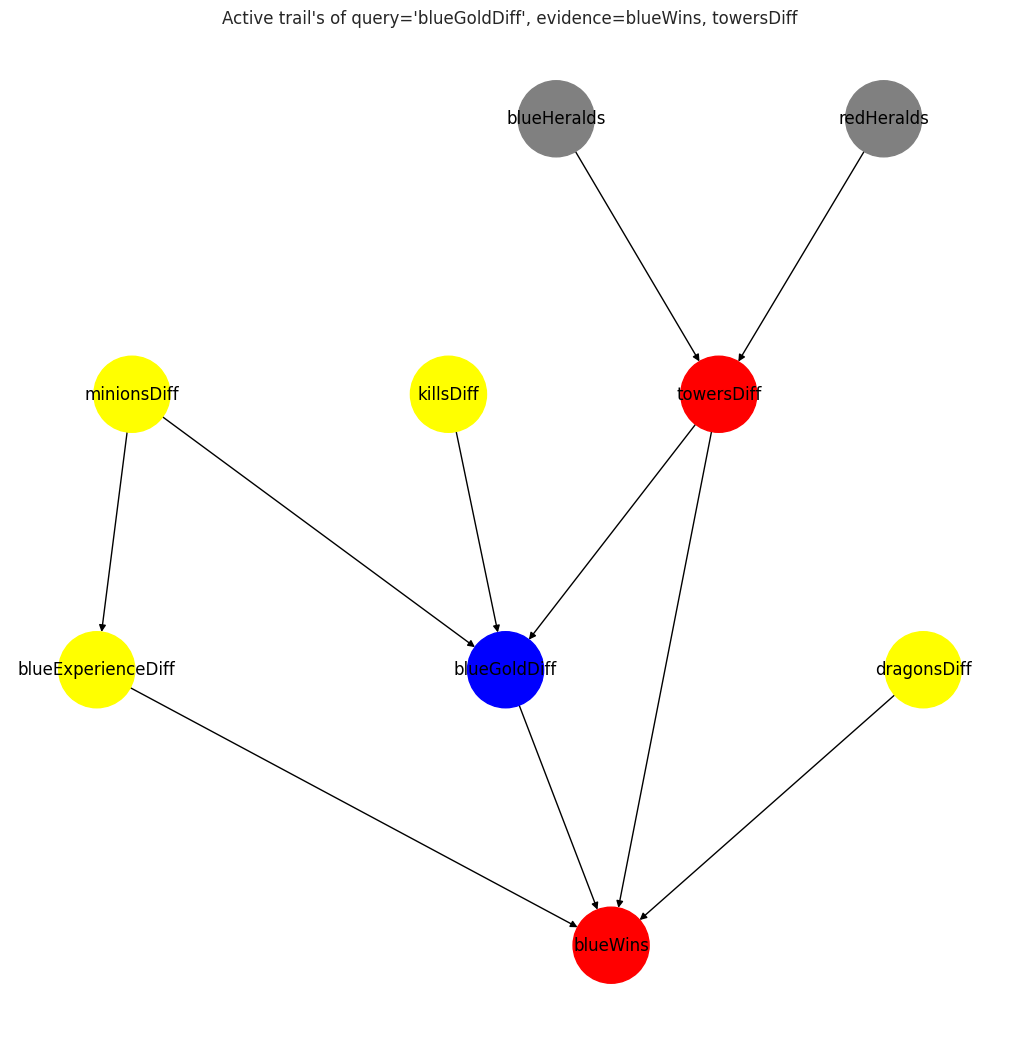

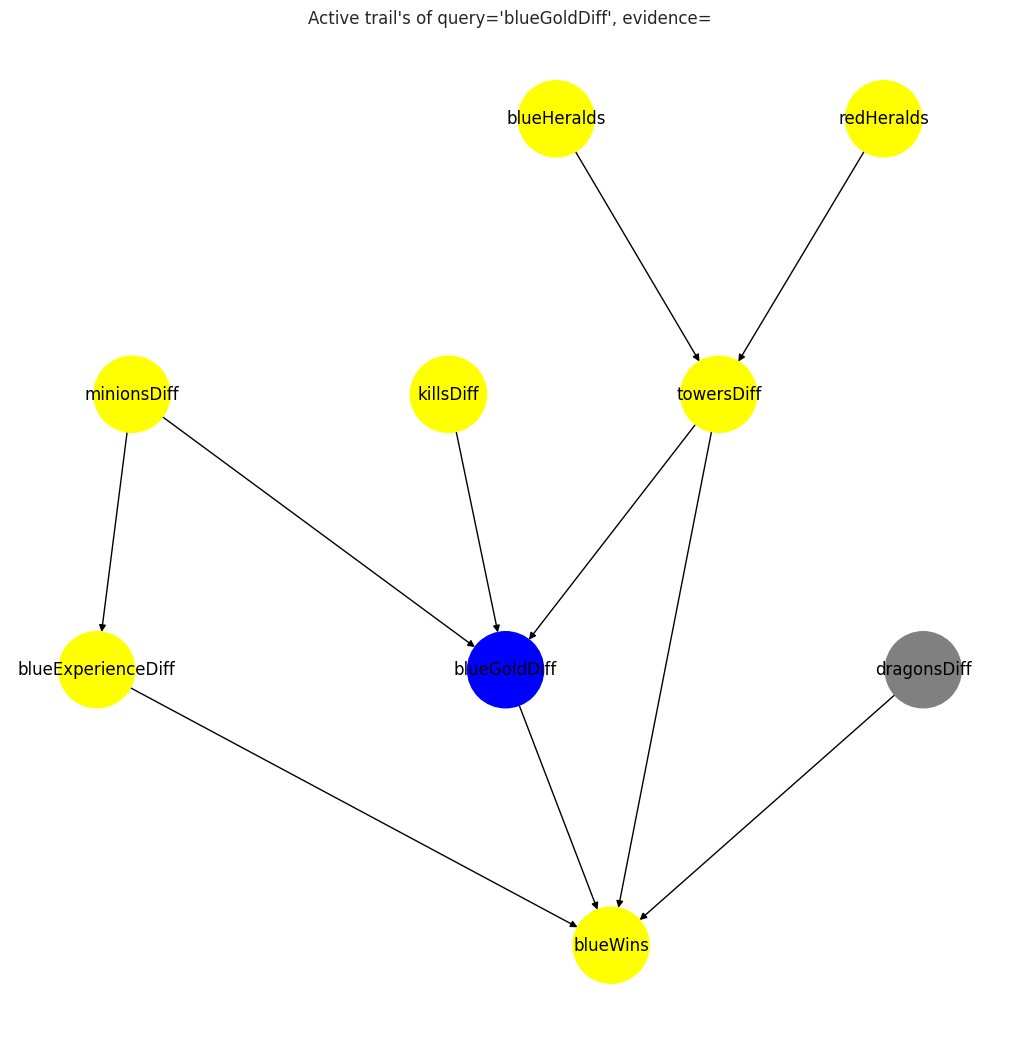

In [239]:
def draw_graph(model, color="green", title="", figsize=(10, 10)):
    pos = graphviz_layout(model, prog="dot")
    plt.figure(figsize=figsize)
    nx.draw(model, with_labels=True, pos=pos, node_size=3000, node_color=color)
    plt.savefig('model.png')
    plt.title(title)
    plt.show()


def draw_markov_blanket_of(node, model):
    blanket = model.get_markov_blanket(node)
    color = ["yellow" if n in blanket else "blue" if n == node else "gray" for n in model.nodes]

    draw_graph(model, color, f"Markov's blanket of {node}")

def draw_active_trail_of(query, evidence, model):
    active = model.active_trail_nodes(query, observed=evidence).get(query)
    active.remove(query)
    color = ["yellow" if n in active else "blue" if n == query else "red" if n in evidence else "gray" for n in model.nodes]

    draw_graph(model, color, f"Active trail's of {query=}, evidence={', '.join(evidence)}")

def draw_independencies(node, model):
    draw_active_trail_of(node, [], model)


draw_markov_blanket_of("blueGoldDiff", manual_model)
draw_markov_blanket_of("blueHeralds", manual_model)
draw_active_trail_of("blueGoldDiff", ["blueWins", "towersDiff"], manual_model)
draw_independencies("blueGoldDiff", manual_model)

#active_trails_of

# Complete dataset test
In this section the entire dataset is used to compute the DAG using the Hill Climbing search.
After, we will compare this model with the others. The aim is: understand how much the absence of all the feature influence the model and its results.

The dataset is discretized similarly to the precedent models. And like the other Hill Climb model, the blueWins variable is black listed. The last step is the parameter learn, done again with the same method.

In [240]:
neutral_positive_aug = ["Neutral", "Positive", "Very Positive"]

def discretize_complete(data):
    dataset = data.copy()


    true_false_dict = {1: "True", 0: "False"}
    true_false_list = ["blueWins", "blueHeralds", "redHeralds", "blueFirstBlood", "redFirstBlood", "blueDragons", "redDragons"]
    to_replace = {v: true_false_dict for v in true_false_list}
    dataset = dataset.replace(to_replace)

    def cut_red_and_blue(key, bins, labels):
        blue_key = f"blue{key}"
        red_key = f"red{key}"

        variables_to_values[blue_key] = labels
        variables_to_values[red_key] = labels

        if blue_key in dataset:
            dataset[blue_key] = pd.cut(dataset[blue_key], bins=bins, labels=labels, include_lowest=True)
        if red_key in dataset:
            dataset[red_key] = pd.cut(dataset[red_key], bins=bins, labels=labels, include_lowest=True)

    cut_red_and_blue("WardsPlaced", [-np.inf, 12, 25, np.inf], neutral_positive_aug)
    cut_red_and_blue("WardsDestroyed", [-np.inf, 4, 8, np.inf], neutral_positive_aug)
    cut_red_and_blue("Kills", [-np.inf, 5, 9, np.inf], neutral_positive_aug)
    cut_red_and_blue("Deaths", [-np.inf, 5, 9, np.inf], neutral_positive_aug)
    cut_red_and_blue("Assists", [-np.inf, 7, 11, np.inf], neutral_positive_aug)
    cut_red_and_blue("EliteMonsters", [-np.inf, 1, 2, np.inf], neutral_positive_aug)
    cut_red_and_blue("TowersDestroyed", [-np.inf, 1, 2, np.inf], neutral_positive_aug)
    cut_red_and_blue("TotalGold", [-np.inf, 13000, 17000, np.inf], neutral_positive_aug)
    cut_red_and_blue("AvgLevel", [-np.inf, 7, 8, np.inf], neutral_positive_aug)
    cut_red_and_blue("TotalExperience", [-np.inf, 17000, 18000, np.inf], neutral_positive_aug)
    cut_red_and_blue("TotalMinionsKilled", [-np.inf, 180, 220, np.inf], neutral_positive_aug)
    cut_red_and_blue("TotalJungleMinionsKilled", [-np.inf, 45, 60, np.inf], neutral_positive_aug)
    cut_red_and_blue("GoldDiff", [-np.inf, -2500, -1000, 1000, 2500, np.inf], negative_neutral_positive_aug)
    cut_red_and_blue("ExperienceDiff", [-np.inf,-2000,-750, 750, 2000, np.inf], negative_neutral_positive_aug)
    cut_red_and_blue("CSPerMin", [-np.inf, 20, 24, np.inf], neutral_positive_aug)
    cut_red_and_blue("GoldPerMin", [-np.inf, 1462, 1851, np.inf], neutral_positive_aug)

    return dataset

path = "high_diamond_ranked_10min.csv"
data = pd.read_csv(path)
data = data.drop("gameId", axis=1)

dataset_complete = discretize_complete(data)
dataset_complete.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,False,Very Positive,Neutral,True,Positive,Positive,Positive,Neutral,False,False,...,Neutral,Positive,Neutral,Positive,Positive,Positive,Neutral,Neutral,Neutral,Positive
1,False,Neutral,Neutral,False,Neutral,Neutral,Neutral,Neutral,False,False,...,Neutral,Very Positive,Neutral,Positive,Very Positive,Positive,Very Positive,Positive,Positive,Positive
2,False,Positive,Neutral,False,Positive,Very Positive,Neutral,Neutral,True,False,...,Neutral,Very Positive,Neutral,Positive,Positive,Neutral,Positive,Positive,Positive,Positive
3,False,Very Positive,Neutral,False,Neutral,Neutral,Neutral,Neutral,False,True,...,Neutral,Positive,Neutral,Positive,Very Positive,Positive,Positive,Neutral,Positive,Positive
4,False,Very Positive,Neutral,False,Positive,Positive,Neutral,Neutral,False,False,...,Neutral,Very Positive,Neutral,Very Positive,Very Positive,Very Positive,Positive,Neutral,Positive,Positive


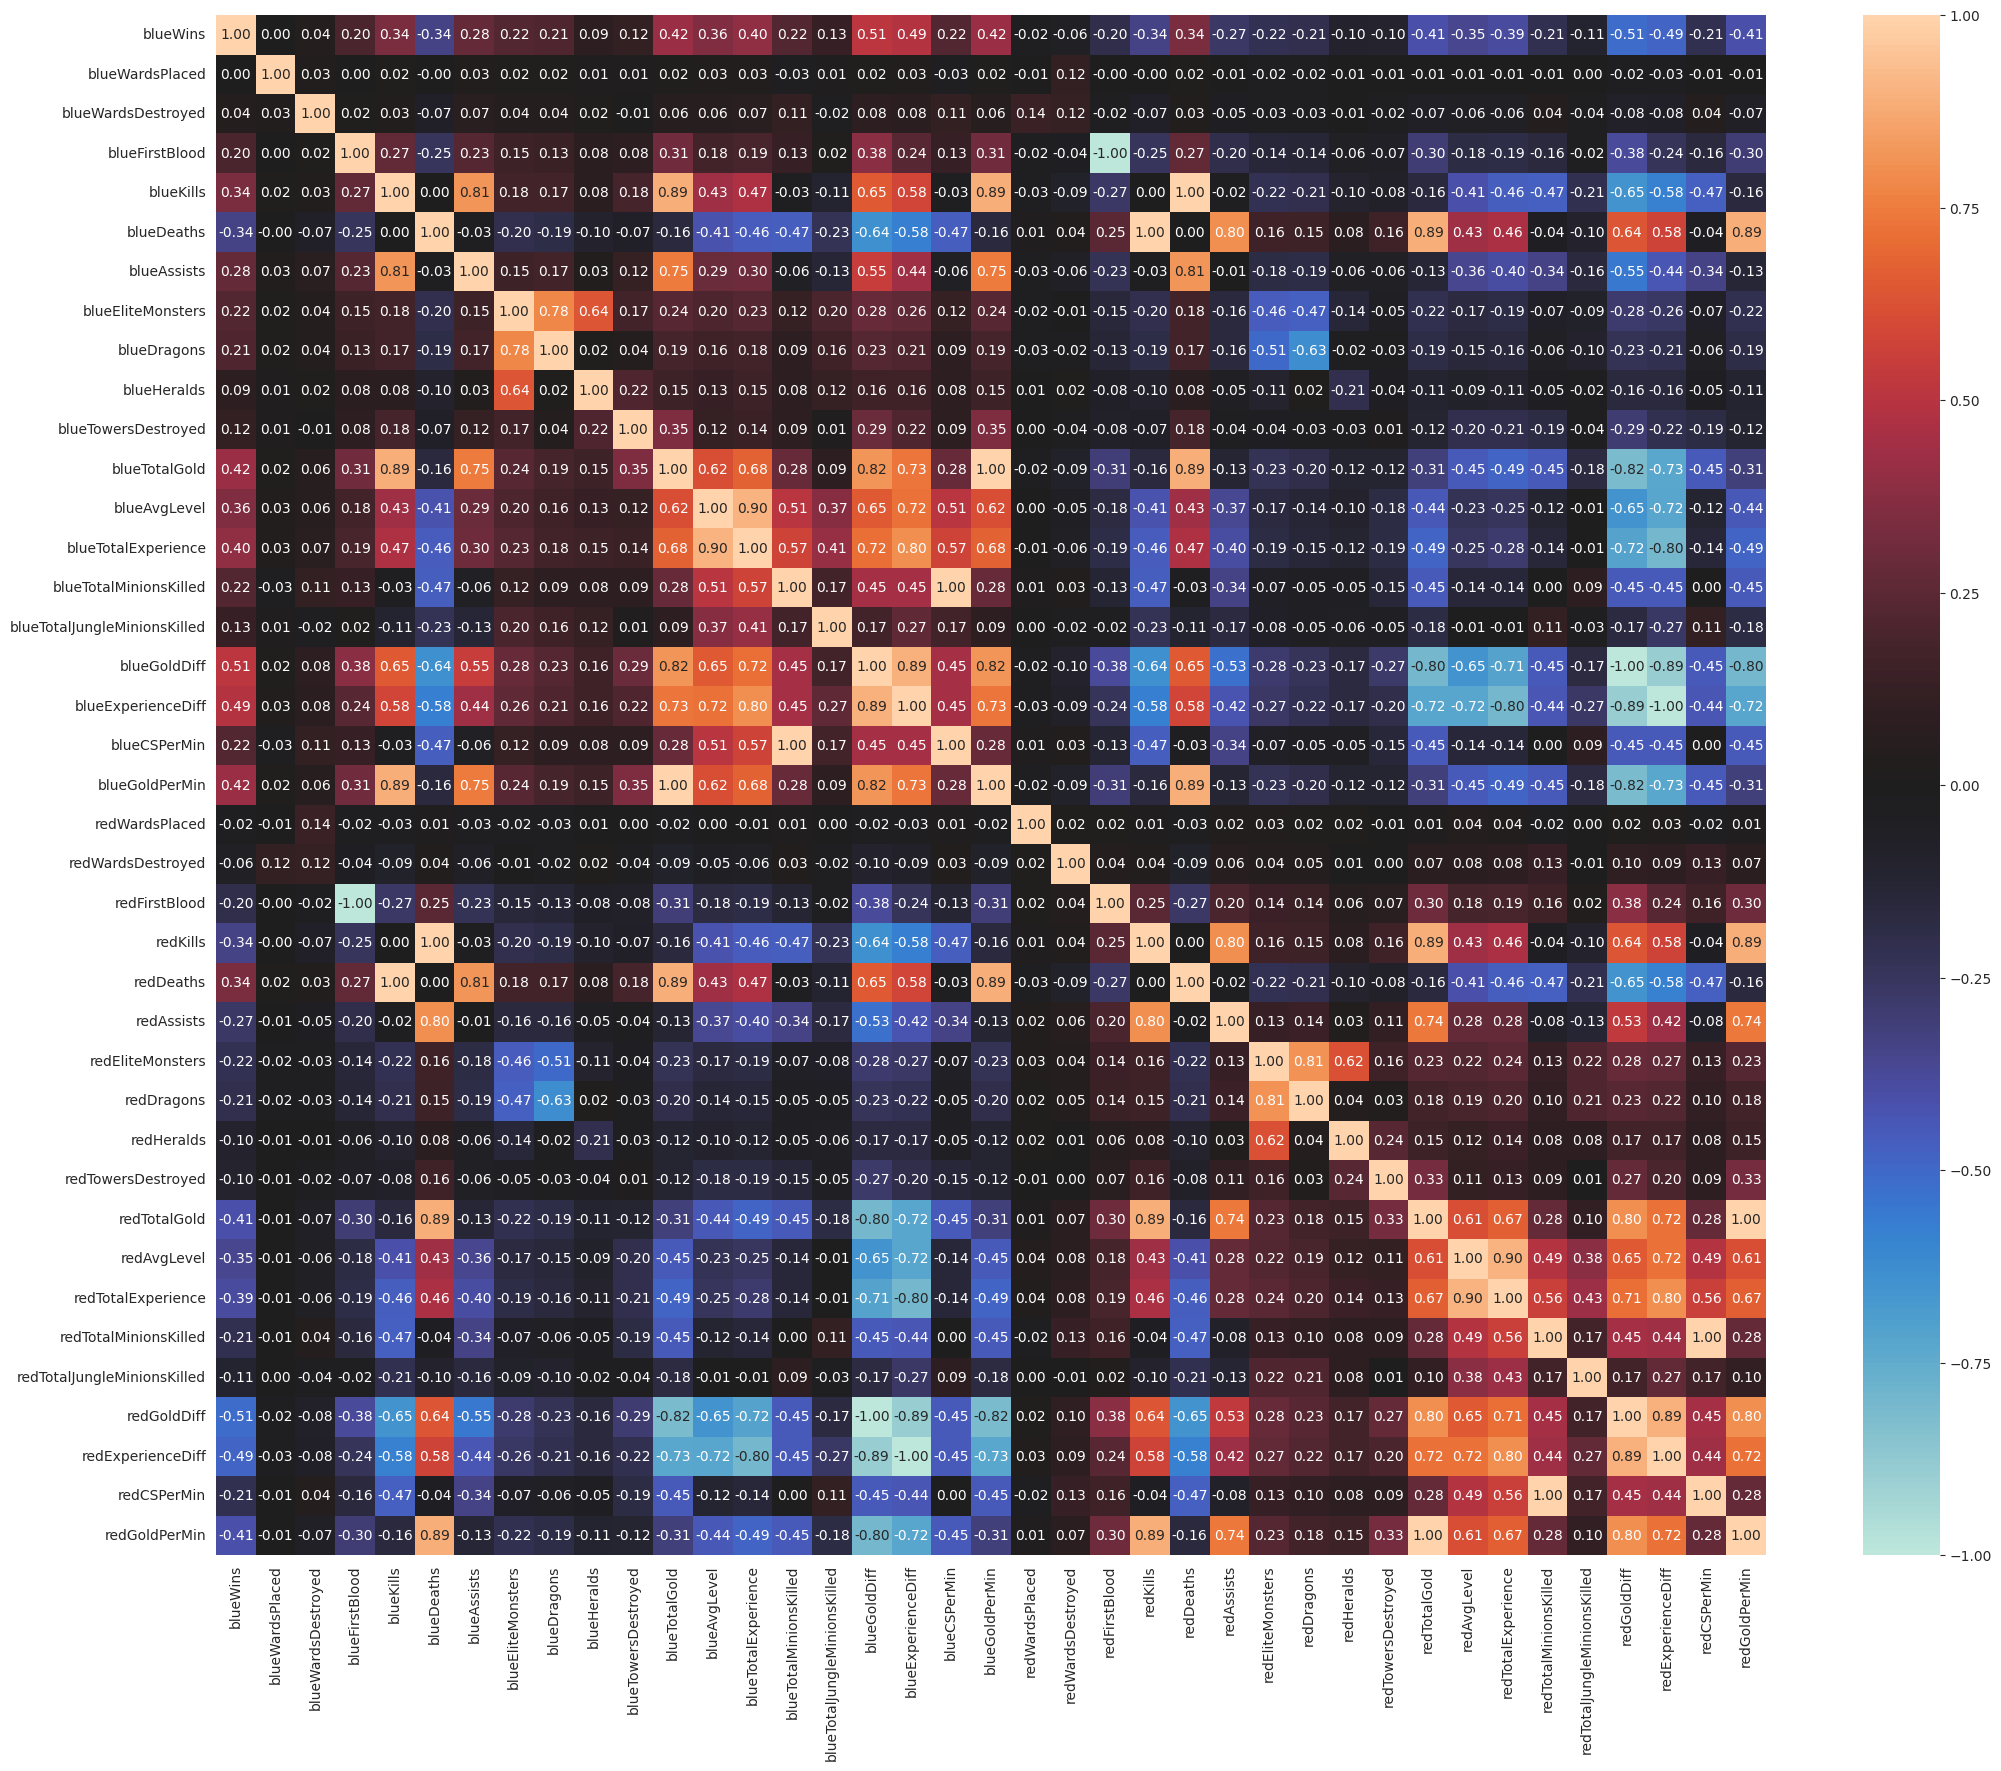

In [241]:
draw_correlation_matrix(data, figsize=(25, 20))

In [242]:
discretized_cleaned_dataset = discretize_complete(data)
discretized_cleaned_dataset.head()


,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,False,Very Positive,Neutral,True,Positive,Positive,Positive,Neutral,False,False,...,Neutral,Positive,Neutral,Positive,Positive,Positive,Neutral,Neutral,Neutral,Positive
1,False,Neutral,Neutral,False,Neutral,Neutral,Neutral,Neutral,False,False,...,Neutral,Very Positive,Neutral,Positive,Very Positive,Positive,Very Positive,Positive,Positive,Positive
2,False,Positive,Neutral,False,Positive,Very Positive,Neutral,Neutral,True,False,...,Neutral,Very Positive,Neutral,Positive,Positive,Neutral,Positive,Positive,Positive,Positive
3,False,Very Positive,Neutral,False,Neutral,Neutral,Neutral,Neutral,False,True,...,Neutral,Positive,Neutral,Positive,Very Positive,Positive,Positive,Neutral,Positive,Positive
4,False,Very Positive,Neutral,False,Positive,Positive,Neutral,Neutral,False,False,...,Neutral,Very Positive,Neutral,Very Positive,Very Positive,Very Positive,Positive,Neutral,Positive,Positive


  0%|          | 0/1000000 [00:00<?, ?it/s]

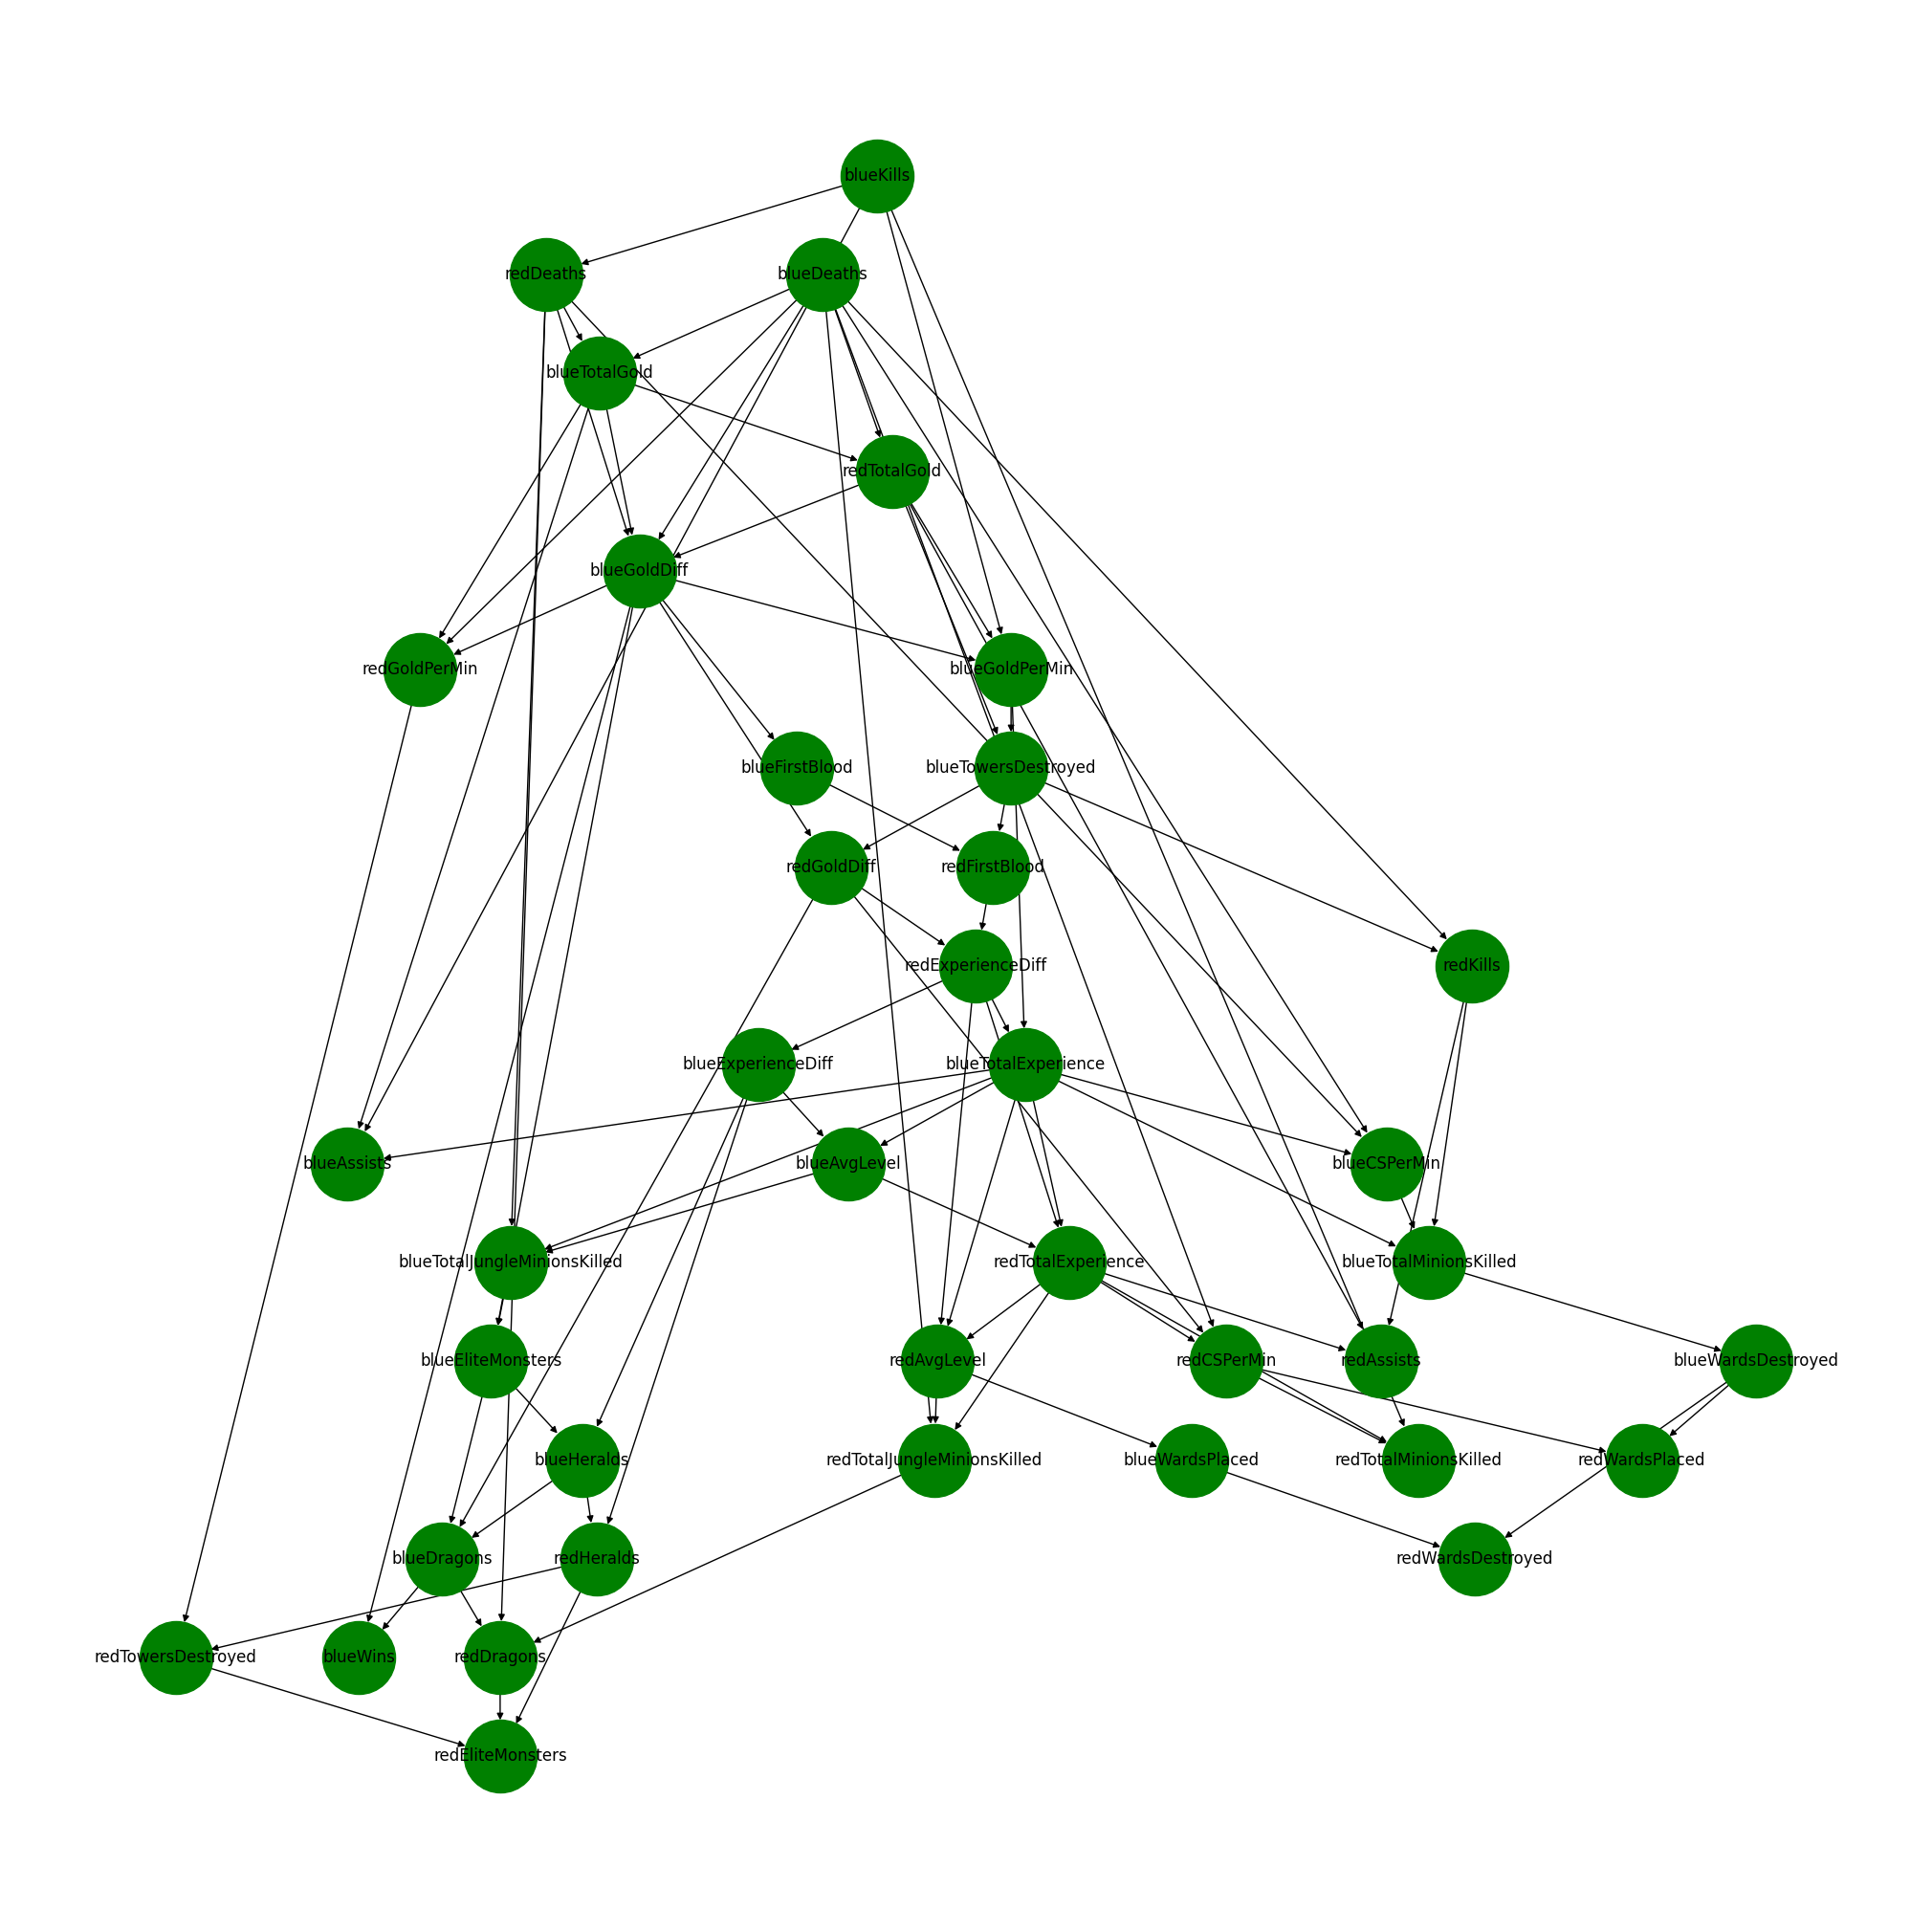

In [243]:
estimator_complete = HillClimbSearch(discretized_cleaned_dataset)


black_list_complete = [('blueWins', node) for node in discretized_cleaned_dataset.columns[:-1]]

hillclimb_model_complete = estimator_complete.estimate(scoring_method=BDsScore(discretized_cleaned_dataset), black_list=black_list_complete)
hillclimb_model_complete = BayesianNetwork(hillclimb_model_complete)
draw_graph(hillclimb_model_complete, figsize=(20, 20))


In [244]:
hillclimb_model_complete.fit(data=discretized_cleaned_dataset,
            estimator=BayesianEstimator,
            prior_type="BDeu",
            equivalent_sample_size=10,
            complete_samples_only=False,
)

hillclimb_model_complete.check_model()

True

# Model comparison

Let's compare our models in terms of structure and results

## Structure analysis
Comparing the two models, made with the same dataset, we can see some differences in terms of connections.

1. As we expected the gold difference influence the win as the dragon difference.
On the other hand, the experience difference doesn't seem to have a direct connection with the probability of winning the game.
2. Another difference is the inversion of the edges for the towers difference and the two heralds. In our model we have this connection in a cause-effect way, while in the hill climbing model we have an effect-cause connection.

3. There is also a dependence between the two heralds that we considered not interesting in our handmade model.
Before the 10 minutes mark in a game there is only one herald available, this means that if a team has a herald the other cannot have it. This type of dependence has been captured from the second model.
4. In opposition of the handmade model, the Hill Climbing model show us that there is no direct dependence between the towers difference and the blue victory.
5. The number of parameters in the Hill Climbing model turns out to be less than the handmade.

For the "full dataset model" we notice:
1. The connection made are straightforward. For example edges like redDeaths -> blueKills or blueKills -> blueAssists.
2. As we expected the variables, also in this full feature network, that directly influence the blueWins are the difference in gold and the dragons. While the blueExperienceDiff and the towers destroyed does not have a direct edge.
3. This net built with all the game features has the highest complexity in terms of parameters.


Another way to compare the models is the BDeu score. This one represents how well the data fit with the model.
Still, this metrics doesn't have a straight forward interpretability and cannot really tell how good a model really is.

In [245]:
def get_num_parameters(model): return sum(
    [len(cpd.get_values().ravel()) for cpd in model.get_cpds()])


models.append(Model(model=hillclimb_model_complete, name="Hillclimb Complete Model", dataset=discretized_cleaned_dataset))

for model in models:
    print(f"Number of parameters in {model.name}: {get_num_parameters(model.model)}")


# N.B. the documentation for bic_score asserts that a model with a higher score fits the data better
for model in models:
    bdeu_score = BDeuScore(model.dataset)
    print(f"BDeuScore in {model.name}: {bdeu_score.score(model.model)}")



Number of parameters in Manual Model: 717
Number of parameters in HillClimb Model: 378
Number of parameters in Hillclimb Complete Model: 2211
BDeuScore in Manual Model: -75443.70022216573
BDeuScore in HillClimb Model: -69113.79852094335
BDeuScore in Hillclimb Complete Model: -178484.642993246


## Results of the models

Now we can compare queries across different models (according to their structure).

The following two queries are very similar. In the second one, we expect a higher probability for the blue team to win the game since we have another positive statistic for the blue team.
This happens only in the first model while in the third we notice a slight decrease of the probability value.

The full Hill Climbing model seems to be counterintuitive.

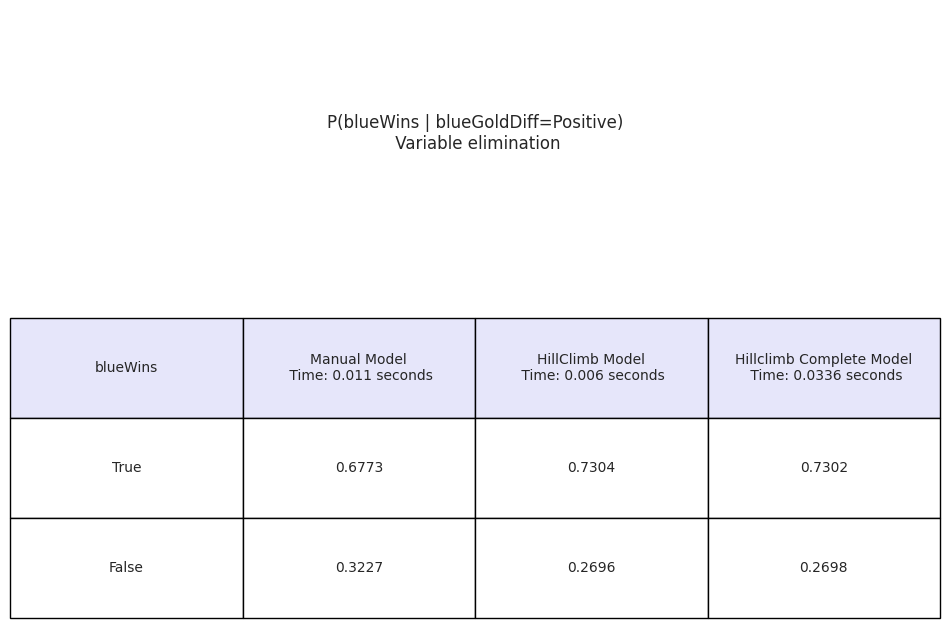

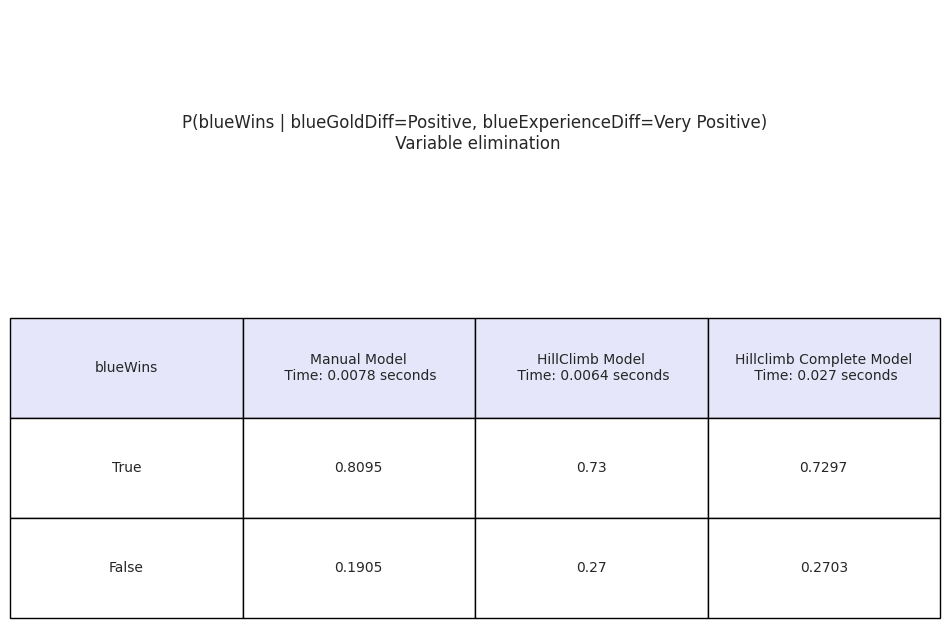

In [246]:
import itertools

plot_query_table(models, ["blueWins"], {"blueGoldDiff": "Positive"}, scale=(6,6))
plot_query_table(models, ["blueWins"], {"blueGoldDiff": "Positive", "blueExperienceDiff": "Very Positive"}, scale=(6,6))

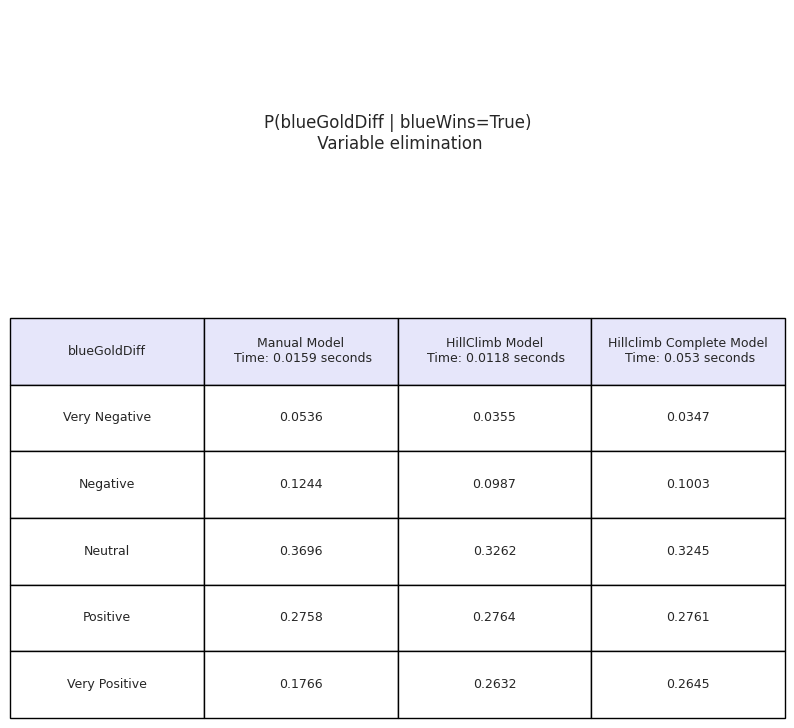

In [247]:
plot_query_table(models, ["blueGoldDiff"], {"blueWins": "True"})

# Approximate inference


Another way to compute queries is the **approximate inference**. This method draws N samples from a distribution and compute an approximate posterior probability. We use the `ApproxInference` class from pgmpy that implements rejection sampling.

In [248]:
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import ApproxInference

n_samples = 100

sampler = BayesianModelSampling(manual_model)
samples = sampler.forward_sample(size=n_samples)

approx_infer = ApproxInference(manual_model)

print(samples)

  0%|          | 0/9 [00:00<?, ?it/s]

   killsDiff   blueGoldDiff minionsDiff blueExperienceDiff towersDiff  \
0    Neutral       Positive     Neutral            Neutral    Neutral   
1    Neutral        Neutral    Positive      Very Positive    Neutral   
2   Positive       Positive    Negative           Negative    Neutral   
3    Neutral        Neutral    Negative      Very Negative    Neutral   
4   Negative  Very Negative    Negative      Very Negative   Negative   
..       ...            ...         ...                ...        ...   
95   Neutral        Neutral     Neutral           Negative    Neutral   
96   Neutral       Negative    Negative      Very Negative    Neutral   
97  Negative        Neutral    Positive           Positive    Neutral   
98  Positive  Very Positive    Positive      Very Positive   Positive   
99  Positive       Positive     Neutral            Neutral    Neutral   

   blueWins blueHeralds redHeralds dragonsDiff  
0     False       False      False    Negative  
1      True       False  

/home/elements72/.local/lib/python3.10/site-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
/home/elements72/.local/lib/python3.10/site-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
/home/elements72/.local/lib/python3.10/site-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
/home/elements72/.local/lib/python3.10/site-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
/home/elements72/.local/lib/python3.10/site-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(


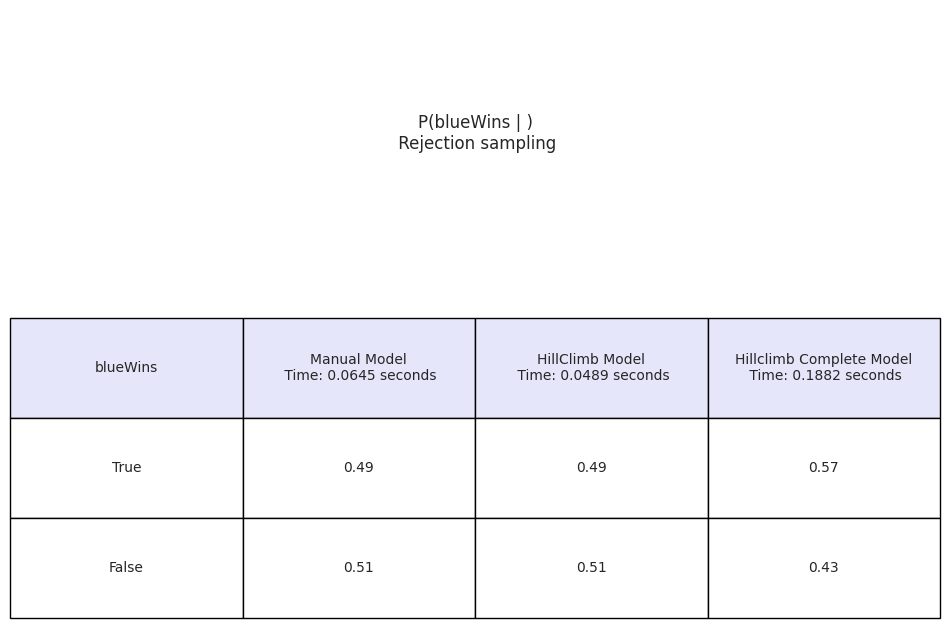

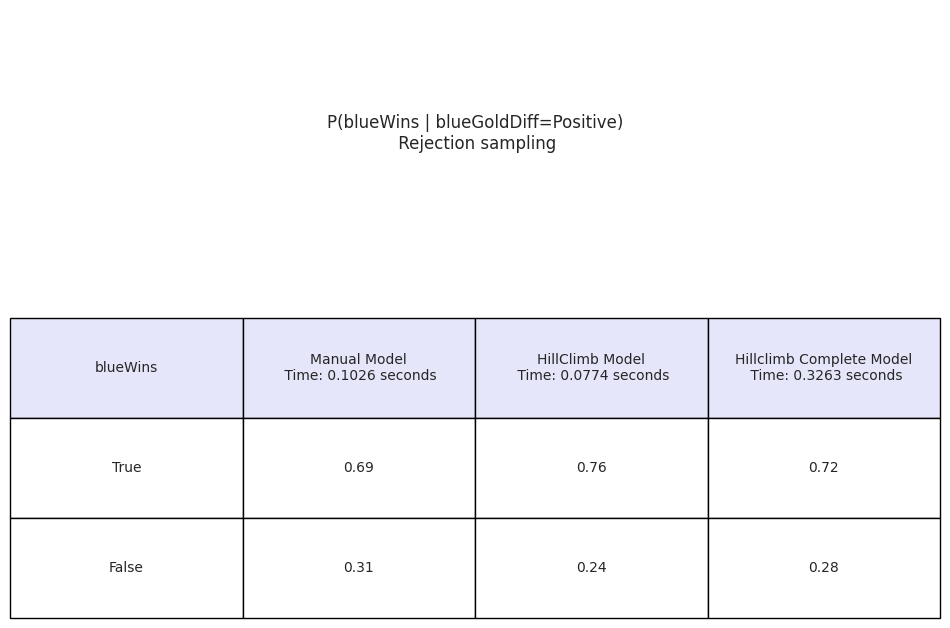

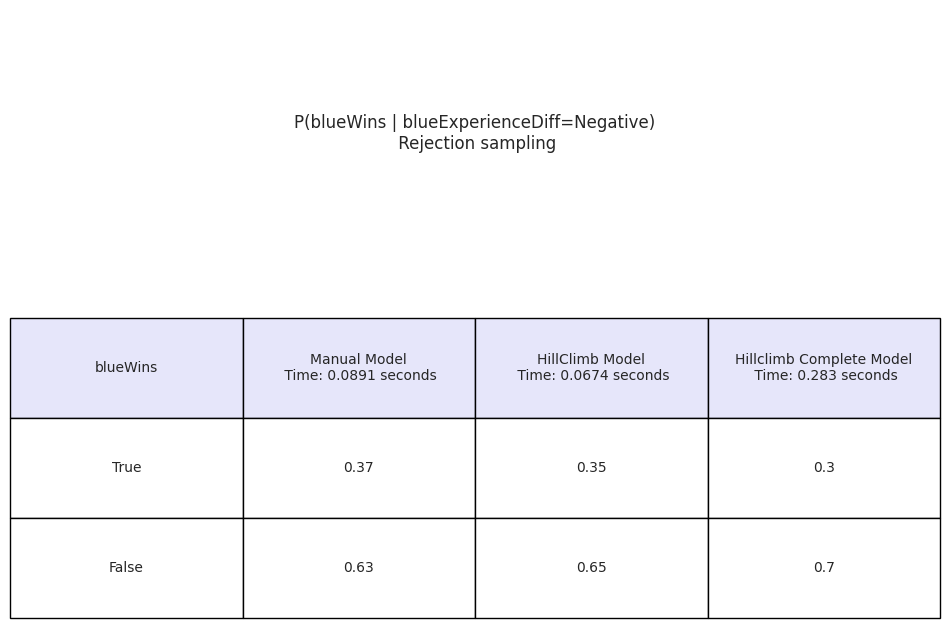

In [249]:
plot_query_table(models, ["blueWins"], {}, scale=(6,6), approximate=True, n_samples=n_samples)
plot_query_table(models, ["blueWins"], {"blueGoldDiff": "Positive"}, scale=(6,6), approximate=True, n_samples=n_samples)
plot_query_table(models, ["blueWins"], {"blueExperienceDiff": "Negative"}, scale=(6,6), approximate=True, n_samples=n_samples)


## Weighted sampling
Another way to make samples is the weighted approach. Each sample has a weight that represent how likely is to have it. For making inference we sum up all the samples weights that match with our evidence. After, we normalize the probability using the total sum of the weighted samples.

In [250]:
def plot_weighted_table(model, time, normalized, targets, evidence, scale=(2,4), fontsize=18):
    ccolors = np.full(len(normalized) + 1, "lavender")
    labels = targets + [model.name + "\n" + str(round(time, 3))]
    data = []
    for key in normalized:
        row = []
        for elem in key:
            value = elem.split(": ")[1]
            row.append(value)
        row.append(round(normalized[key], 3))
        data.append(row)

    fig, ax1 = plt.subplots(figsize=(len(data) + 2, len(labels)))

    table = ax1.table(cellText=data,
                      cellLoc = "center",
                      colLabels= labels,
                      colColours = ccolors,
                      loc="bottom"
                      )
    table.scale(*scale)
    table.set_fontsize(fontsize)
    ax1.axis("off")

    title = f"P({', '.join(targets)} | {', '.join([f'{k}={v}' for (k, v) in evidence.items()])})\n Weighetd sampling"

    ax1.set_title(title, y=1.0, pad=-100)

def buckets(targets, samples, weight_column_name):
    targets_values = {}
    # For each variable we declare a dict with all occurrences possible values:
    # {target1: (target1: value, target1: value2, ...) ...}
    for target in targets:
        key = tuple([str(target)+ ": " + str(value) for value in variables_to_values[target]])
        targets_values[target] = key
    # We compute the cartesian product between all the values of all the targets variables
    keys = list(itertools.product(*targets_values.values()))
    occurrences = {key: 0 for key in keys}

    for i, sample in samples.iterrows():
        key = tuple([str(target)+ ": " + str(value) for value, target in zip(sample[targets], targets)])
        occurrences[key] += sample[weight_column_name]
    return occurrences

def normalize_dict(dict, normalization_factor):
    for key in dict:
        dict[key] = dict.get(key) / normalization_factor
    return dict



In [251]:
from pgmpy.factors.discrete import State

evidences = {"blueGoldDiff": "Very Positive"}
evidences_state = [State(key, value) for key, value in evidences.items()]
samples = sampler.likelihood_weighted_sample(evidence=evidences_state, size=n_samples, show_progress=False)
print(samples)

# computing normalization factor
total_sum_of_weights = sum(samples["_weight"])

targets = ["blueWins"]
weight_column_name = "_weight"


        killsDiff   blueGoldDiff minionsDiff blueExperienceDiff towersDiff  \
0        Negative  Very Positive    Positive           Positive   Negative   
1         Neutral  Very Positive     Neutral            Neutral    Neutral   
2   Very Negative  Very Positive    Negative      Very Negative    Neutral   
3         Neutral  Very Positive     Neutral           Negative    Neutral   
4         Neutral  Very Positive    Negative           Negative    Neutral   
..            ...            ...         ...                ...        ...   
95        Neutral  Very Positive    Positive            Neutral    Neutral   
96       Negative  Very Positive     Neutral           Negative    Neutral   
97        Neutral  Very Positive    Positive      Very Positive    Neutral   
98        Neutral  Very Positive    Positive           Positive    Neutral   
99  Very Negative  Very Positive    Negative      Very Negative    Neutral   

   blueWins blueHeralds redHeralds dragonsDiff   _weight  
0   

/home/elements72/.local/lib/python3.10/site-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(


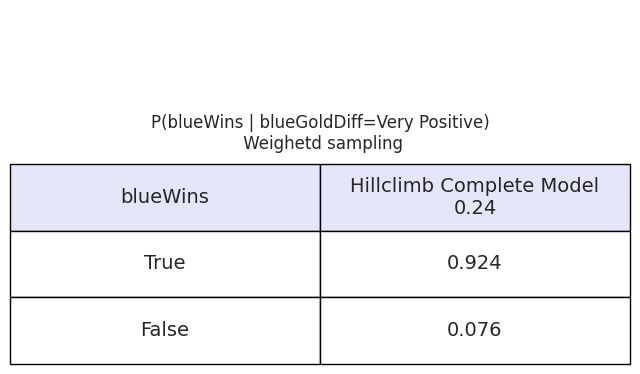

In [252]:
def weighted_inference(model, targets, evidences):
    start_time = time.time()
    sampler = BayesianModelSampling(model.model)
    evidences_state = [State(key, value) for key, value in evidences.items()]
    samples = sampler.likelihood_weighted_sample(evidence=evidences_state, size=n_samples, show_progress=False)
    W = buckets(targets, samples, weight_column_name)
    total_sum_of_weights = sum(samples[weight_column_name])

    normalized = normalize_dict(W, total_sum_of_weights)

    end_time = time.time()

    plot_weighted_table(model, end_time-start_time, normalized, targets, evidences)

weighted_inference(models[2], targets, evidences)

## Variable elimination vs sampling
Let's compare the execution time of the variable elimination method and the rejection sampling.
The first query has a small number of evidence and the expectation is to have a better time of execution both for variable elimination and rejection sampling.

The second query has more evidence, in this case the weighted sampling should be the best.

/home/elements72/.local/lib/python3.10/site-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
/home/elements72/.local/lib/python3.10/site-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
/home/elements72/.local/lib/python3.10/site-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(


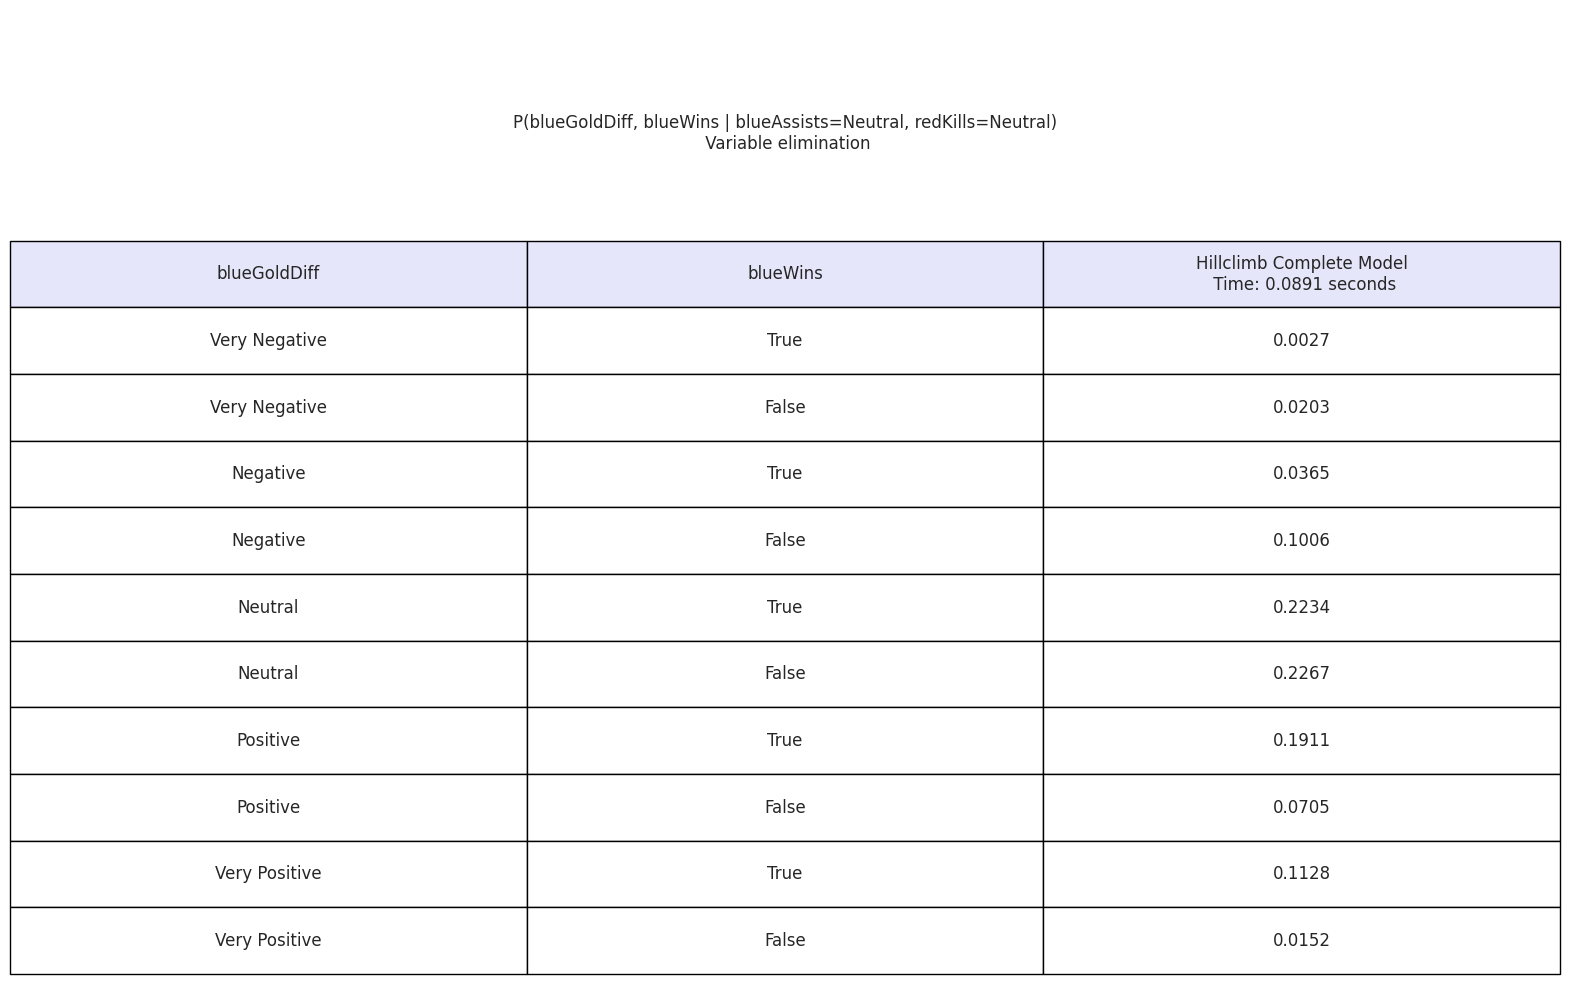

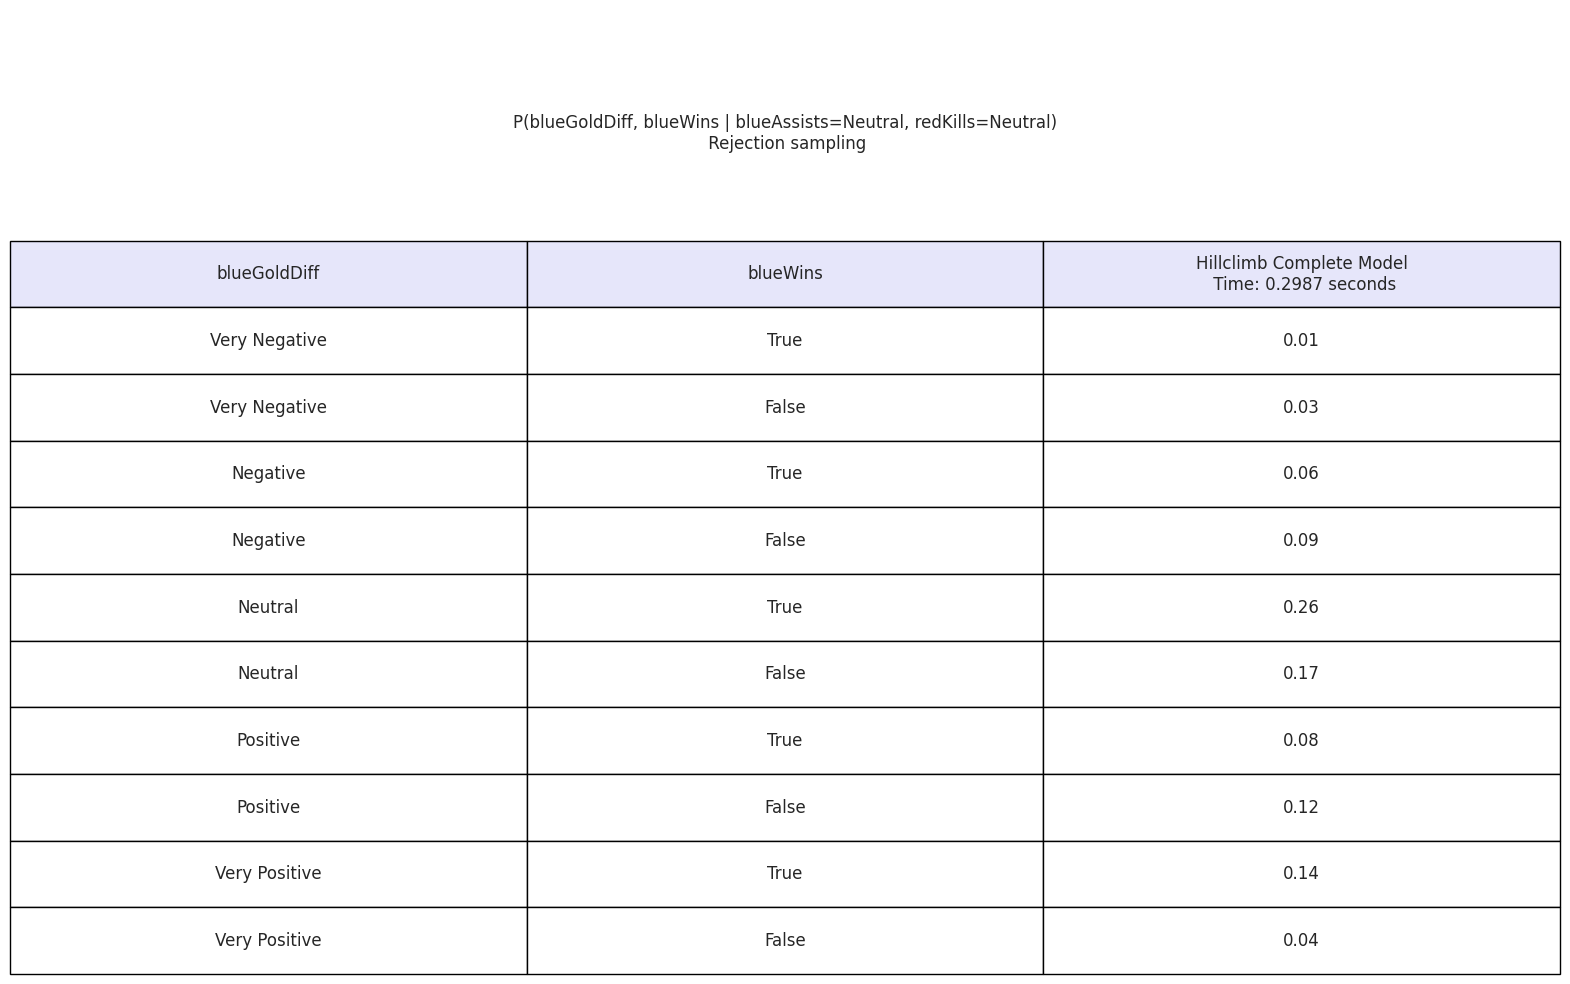

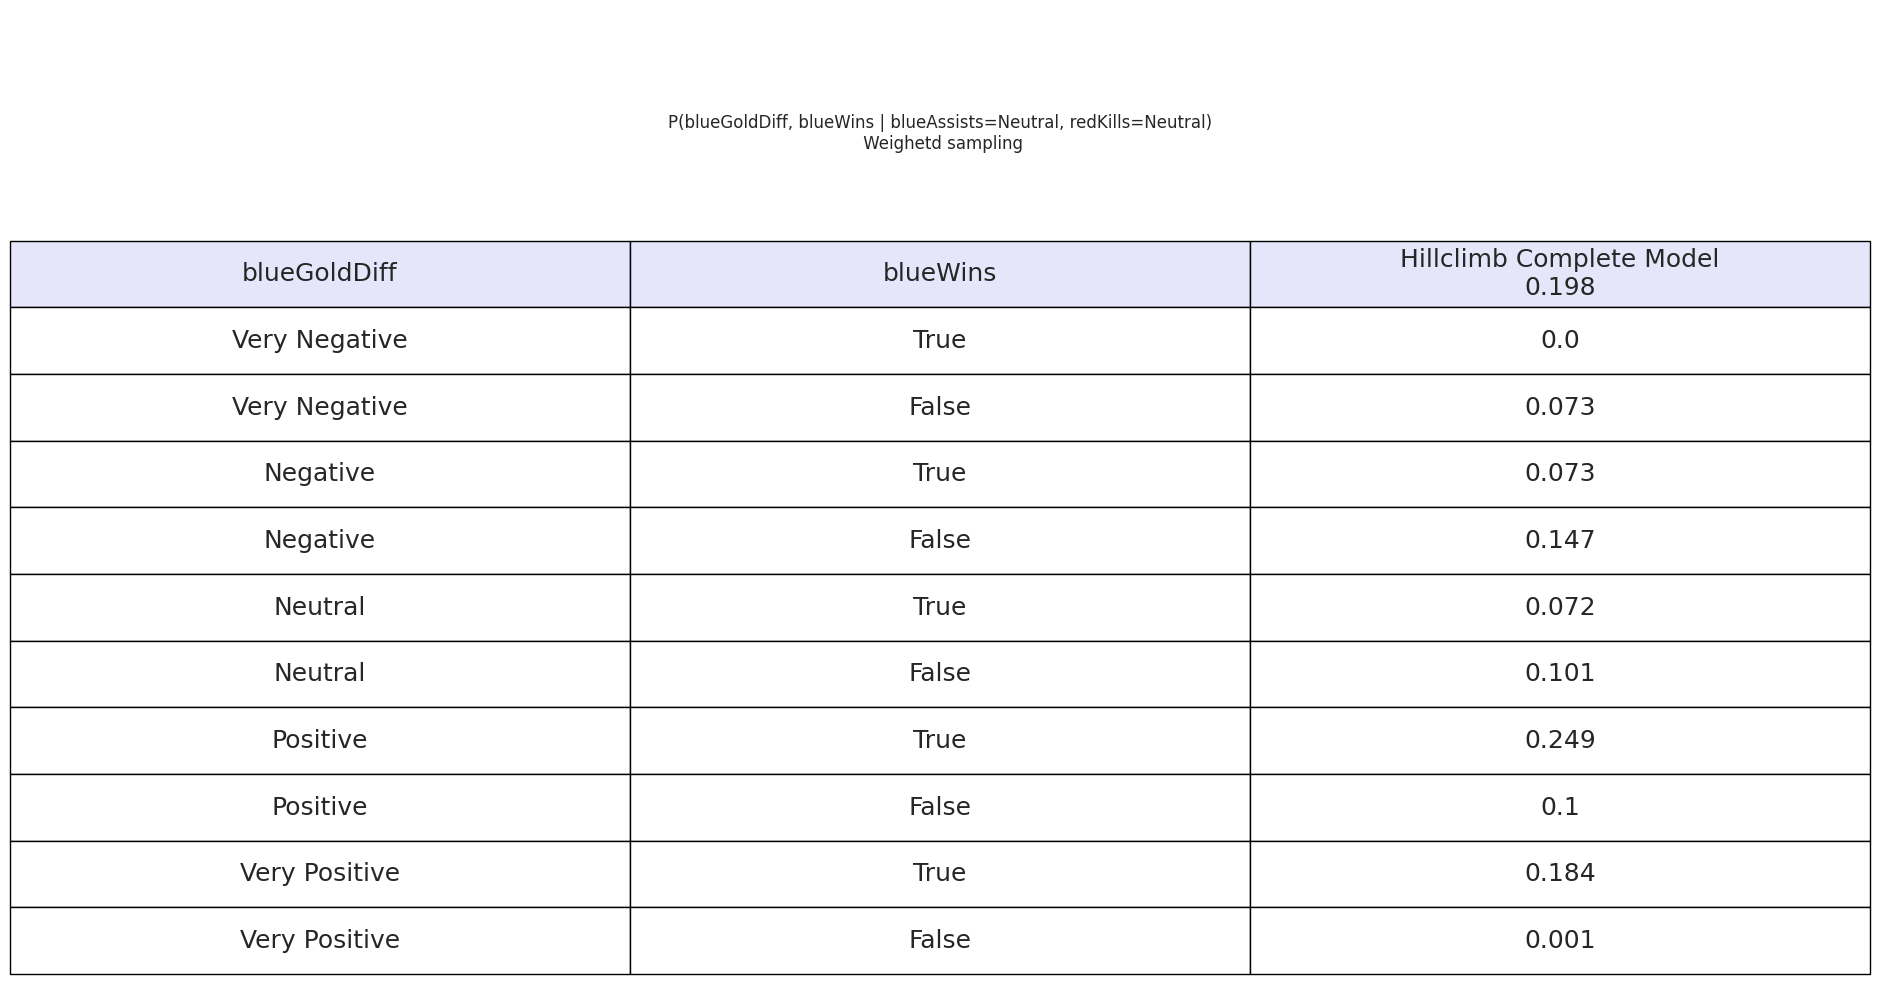

In [262]:
targets = ["blueGoldDiff", "blueWins"]
evidences = {"blueAssists": "Neutral", "redKills": "Neutral"}
plot_query_table([models[-1]], targets, evidences, scale=(2,4))
plot_query_table([models[-1]], targets, evidences, approximate=True, n_samples=n_samples, scale=(2,4))
weighted_inference(models[-1] , targets, evidences)


/home/elements72/.local/lib/python3.10/site-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
/home/elements72/.local/lib/python3.10/site-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
/home/elements72/.local/lib/python3.10/site-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(


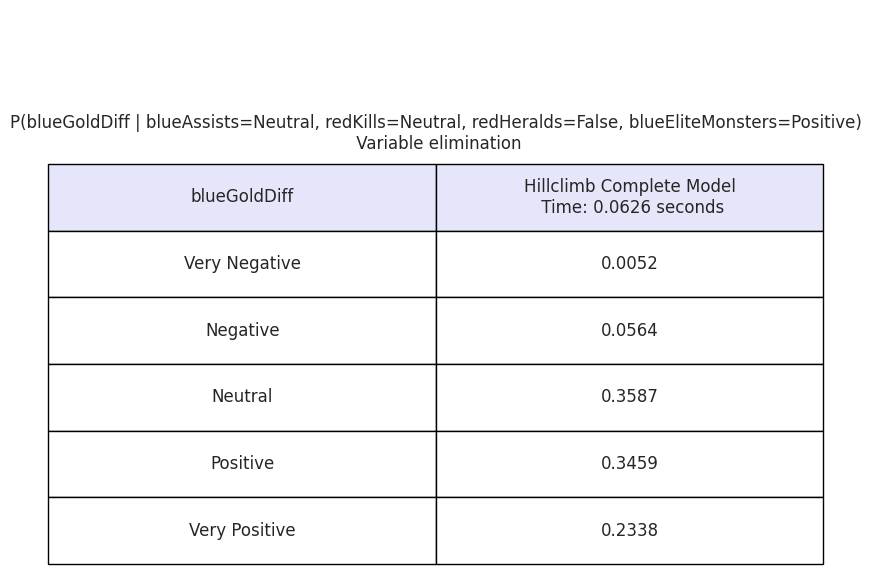

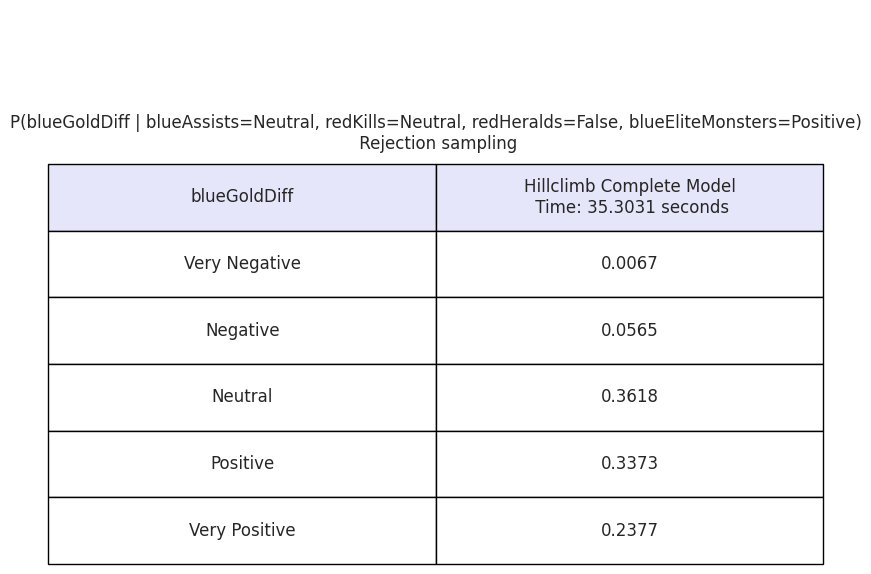

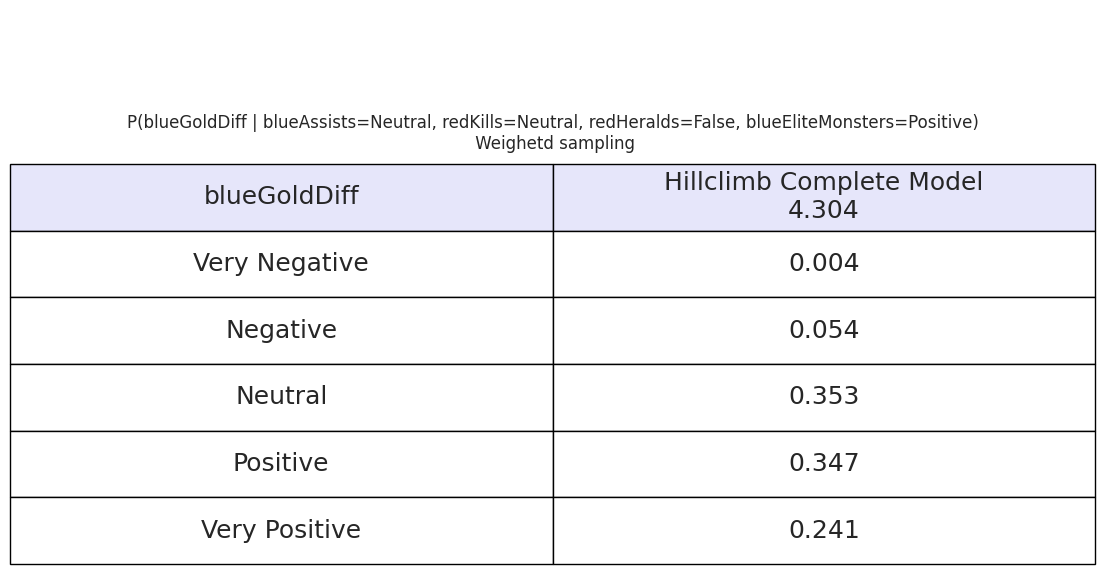

In [263]:
n_samples = 10000

targets = ["blueGoldDiff"]
evidences = {"blueAssists": "Neutral", "redKills": "Neutral", "redHeralds": "False",
             "blueEliteMonsters": "Positive"}
plot_query_table([models[-1]], targets, evidences, scale=(2,4))
plot_query_table([models[-1]], targets, evidences, approximate=True, n_samples=n_samples, scale=(2,4))
weighted_inference(models[-1] , targets, evidences)



# Conclusion
We saw an application of Bayesian network on the League of Legends game. We started from a dataset containing the statistics at 10 minutes of the games. We discretize it and make our own features to analyze the dependencies between them.

We made three different models:
1. Manual model: made using our knowledge of the game
2. Hill Climbing model: made with the Hill Climb algorithm
3. Full Hill Climbing model: made with the original discretized features

In general, the Bayesian network with all the dataset feature captures more relations than the manual one, despite this, we prefer a simpler net using only the feature that we decided to be interesting. It's clear that: in a game all the features influence each other but also a subset of that can be sufficient to capture the major relations.

The three models are able to capture relations between features reflecting our expectation. For example, in all models the gold difference is crucial for winning. Another example is the dependence between the heralds, in 10 minutes only a team can have one.


After we make several queries using the **variable elimination** method. The results between the models (manual and hill climbing) are quite similar, we did not notice any controuintive probability. The full feature model is hardly comparable with the others because of its structure which is completely different. The only type of comparison possible between all the three models is the BDeu score. Analyzing the scores we found that the Hill Climbing model was the one that better fits the data, the full Hill Climbing model is the worst, because its more difficult to fit all the dataset features.


As final test we use sampling and **approximate inference** for query, we observed that:
1. More samples implies a better approximation of the original distribution.
2. Both the sampling methods are good approximation of the variable elimination.
3. Counter-intuitively this approach is more time consuming then the variable elimination.
4. The weighted sampling method results to be faster than the rejection sampling in queries with many evidence.

In conclusion the presented models represent an approximation of the infinite variables (and their relation) that influence the course of a match. A possible use of this model is in real live matches. The creators of the game, indeed, provides some APIs to retrieve information about live games. Once the information are retrieved the model can be used to do inference about the possible end of the match.